# DATA INSIGHTS

In [1]:
import numpy as np
import pandas as pd
import tqdm
import os
import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.style as style 
import seaborn as sns
import re, string
%matplotlib inline

import datetime as dt
import ciso8601

from datetime import timedelta
from pprintpp import pprint as pp
from termcolor import colored
from wordcloud import WordCloud, STOPWORDS
from statistics import mean

sns.set_style('darkgrid')
sns.set_context('paper')
style.use('ggplot')
matplotlib.rcParams['font.family'] = 'helvetica'
matplotlib.rcParams['figure.titlesize'] = 'large'

In [2]:
def import_submissions():
    path = './submissions_scraped/'
    files = []
    for filename in os.listdir(path):
        files.append(pd.read_csv(os.path.join(path, filename)))

    files = pd.concat(files)
    df_submissions = pd.DataFrame(files)
    df_submissions.drop(columns=['Unnamed: 0'], inplace=True)
    df_submissions.dropna(inplace=True)
    return df_submissions

In [3]:
def import_comments():
    df_comments = pd.read_csv('./comments_scraped/comments.csv')
    df_comments.drop(columns=['Unnamed: 0'], inplace=True)
    df_comments.dropna(inplace=True)
    return df_comments

In [4]:
def import_submissions_previous():
    path = './submissions_scraped_previous/'
    files = []
    for filename in os.listdir(path):
        files.append(pd.read_csv(os.path.join(path, filename)))

    files = pd.concat(files)
    df_submissions = pd.DataFrame(files)
    df_submissions.drop(columns=['Unnamed: 0'], inplace=True)
    
    return df_submissions

In [5]:
def import_comments_previous():
    df_comments = pd.read_csv('./comments_scraped_previous/comments.csv')
    df_comments.drop(columns=['Unnamed: 0'], inplace=True)
    return df_comments

In [6]:
def clean_text(text): 
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower()
    text = re.sub('^\[removed\]|^\[deleted\]', '', str(text))
    text = re.sub('^\[deleted by user\]', '', str(text))
    text = re.sub('^nan', '', str(text))
    text = re.sub(r'#', '',  str(text))
    text = re.sub(r"(?:\@|https?\://)\S+", "", str(text))
    text = re.sub(r'[^\x00-\x7f]',r'', str(text))
    text = re.sub(r'www\S+', '',  str(text)) 
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

In [7]:
subreddits = ['CrohnsDisease', 'IBD', 'UlcerativeColitis', 'ibs']
colors = ['#cc5a49', '#4586ac', '#9e97cc', '#777777']

# Data before 12-2020
df_sub_prev = import_submissions_previous()
df_comm_prev = import_comments_previous()

# Data after 12-2020
df_sub_aft = import_submissions()
df_comm_aft = import_comments()

df_submissions = pd.concat([df_sub_prev, df_sub_aft])
df_comments = pd.concat([df_comm_prev, df_comm_aft])

df_submissions['title_and_body'] = df_submissions['title'] + '' + df_submissions['body']
df_submissions['title_and_body'] = df_submissions['title_and_body'].apply(lambda x: clean_text(str(x)))

df_comments['body'] = df_comments.body.apply(lambda x: clean_text(str(x)))

df_submissions = df_submissions[df_submissions['title_and_body'] != '']
df_comments = df_comments[df_comments['body'] != '']

df_submissions['created'] = pd.to_datetime(df_submissions['created'])
df_comments['created'] = pd.to_datetime(df_comments['created'])
df_comments = df_comments[df_comments['created'] < dt.datetime(2022, 10, 1)]

## Data stats

In [8]:
subreddits = ['CrohnsDisease', 'IBD', 'UlcerativeColitis', 'ibs']
colors = ['#cc5a49', '#4586ac', '#9e97cc', '#777777']

df_crohns = df_submissions[df_submissions['subreddit'] == 'CrohnsDisease']
df_ibs = df_submissions[df_submissions['subreddit'] == 'ibs']
df_ibd = df_submissions[df_submissions['subreddit'] == 'IBD']
df_ulc = df_submissions[df_submissions['subreddit'] == 'UlcerativeColitis']

crohns_comments_scraped = df_comments[df_comments['subreddit'] == 'CrohnsDisease']['id'].count()
ulc_comments_scraped = df_comments[df_comments['subreddit'] == 'UlcerativeColitis']['id'].count()
ibs_comments_scraped = df_comments[df_comments['subreddit'] == 'ibs']['id'].count()
ibd_comments_scraped = df_comments[df_comments['subreddit'] == 'IBD']['id'].count()

In [9]:
print(colored('SUBMISSIONS\n', color='blue', attrs=['bold']))

print(f'\tNumber of subsmissions:\t\t{df_submissions.shape[0]}\n')
print(f'\tNumber of authors:\t\t{df_submissions.author.isnull().sum()}\n')
print('\tW\ at least 1 comment:\t\t', len(df_submissions[df_submissions['num_comments'] > 0]), '\n')

print(colored('COMMENTS\n', color='blue', attrs=['bold']))

print(f'\tNumber of comments:\t\t{df_comments.shape[0]}\n')

print(colored('SUBREDDITS\n', color='blue', attrs=['bold']))
print(f'\tSubreddits scraped: \t{subreddits}\n')

print(colored('\tr/CrohnsDisease\n', color='blue'))
print(f'\t\tNumber of submissions:\t{df_crohns.shape[0]}\n')
print(f'\t\tComments scraped:\t{crohns_comments_scraped}\n')
unique_authors = df_crohns.shape[0] - df_crohns.author.isnull().sum()
print(f'\t\tUnique authors in sr:\t{unique_authors}\n')

print(colored('\tr/UlcerativeColitis\n', color='blue'))
print(f'\t\tNumber of submissions:\t{df_ulc.shape[0]}\n')
print(f'\t\tComments scraped:\t{ulc_comments_scraped}\n')
unique_authors = df_ulc.shape[0] - df_ulc.author.isnull().sum()
print(f'\t\tUnique authors in sr:\t{unique_authors}\n')

print(colored('\tr/ibs\n', color='blue'))
print(f'\t\tNumber of submissions:\t{df_ibs.shape[0]}\n')
print(f'\t\tComments scraped:\t{ibs_comments_scraped}\n')
unique_authors = df_ibs.shape[0] - df_ibs.author.isnull().sum()
print(f'\t\tUnique authors in sr:\t{unique_authors}\n')

print(colored('\tr/IBD\n', color='blue'))
print(f'\t\tNumber of submissions:\t{df_ibd.shape[0]}\n')
print(f'\t\tComments scraped:\t{ibd_comments_scraped}\n')
unique_authors = df_ibd.shape[0] - df_ibd.author.isnull().sum()
print(f'\t\tUnique authors in sr:\t{unique_authors}\n')

print(colored('EMPTY VALUES SUBMISSIONS\n', color='blue', attrs=['bold']))
print(df_submissions.isnull().sum().sort_values(ascending = False), '\n')

print(colored('EMPTY VALUES COMMENTS\n', color='blue', attrs=['bold']))
print(df_comments.isnull().sum().sort_values(ascending = False), '\n')

SUBMISSIONS

	Number of subsmissions:		82462

	Number of authors:		14440

	W\ at least 1 comment:		 75300 

COMMENTS

	Number of comments:		480165

SUBREDDITS

	Subreddits scraped: 	['CrohnsDisease', 'IBD', 'UlcerativeColitis', 'ibs']

	r/CrohnsDisease

		Number of submissions:	25255

		Comments scraped:	172994

		Unique authors in sr:	21178

	r/UlcerativeColitis

		Number of submissions:	16939

		Comments scraped:	109178

		Unique authors in sr:	15093

	r/ibs

		Number of submissions:	36562

		Comments scraped:	176659

		Unique authors in sr:	28621

	r/IBD

		Number of submissions:	3706

		Comments scraped:	21334

		Unique authors in sr:	3130

EMPTY VALUES SUBMISSIONS

author            14440
url               12534
title                 0
score                 0
id                    0
subreddit             0
num_comments          0
body                  0
created               0
title_and_body        0
dtype: int64 

EMPTY VALUES COMMENTS

author       13202
parent_id        0
score

## Data Visualization 

### Submissions analysis 

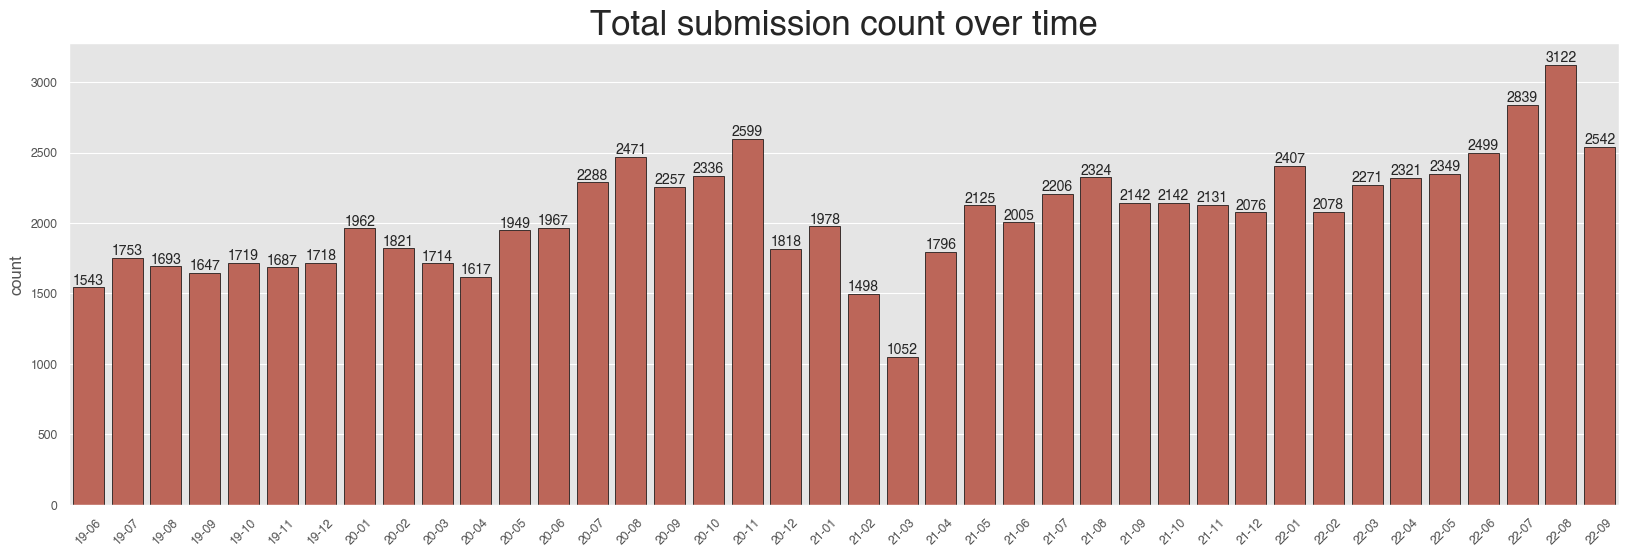

In [10]:
submissions_per_month = df_submissions['created'].dt.strftime('%y-%m').value_counts().sort_index().reset_index(name='counts')

plt.figure(figsize=(20,6))
ax = sns.barplot(x='index', y='counts', data=submissions_per_month, edgecolor='black', color=colors[0])
plt.title('Total submission count over time', fontsize=25)
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.xticks(rotation=45)

plt.show()

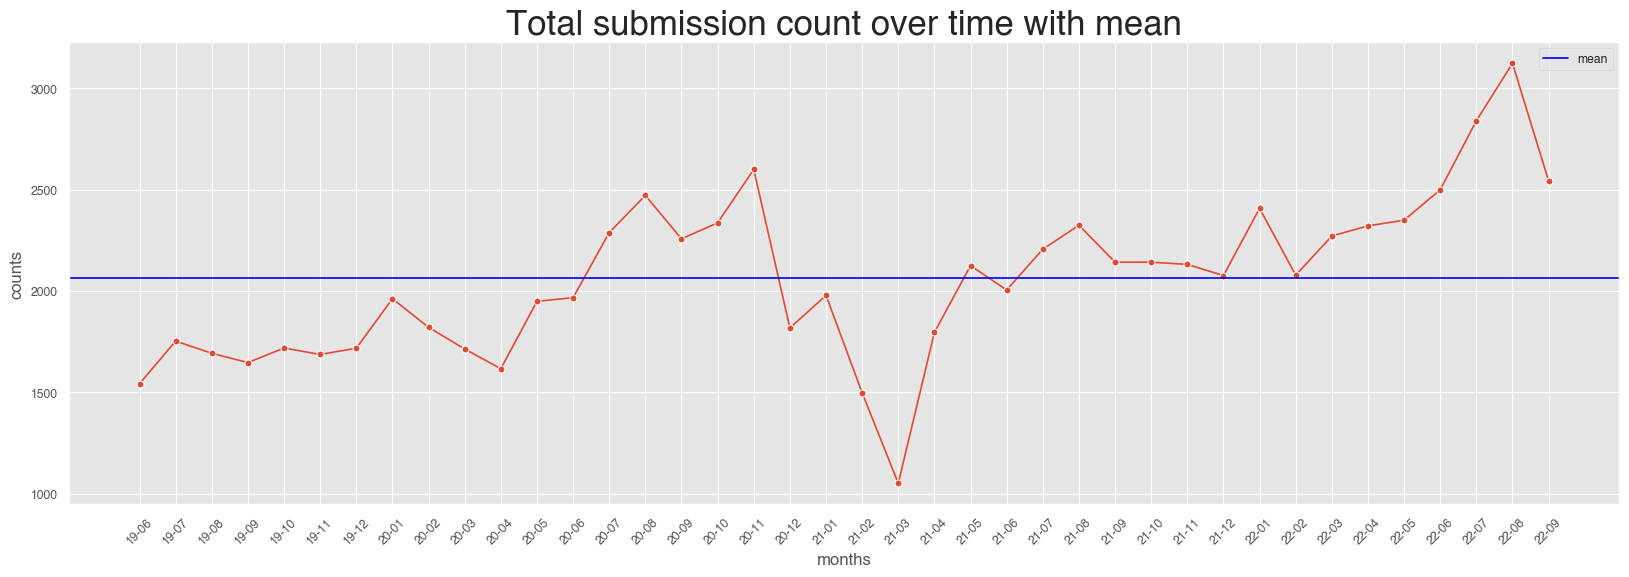

In [11]:
submissions_per_month = df_submissions['created'].dt.strftime('%y-%m').value_counts().sort_index().reset_index(name='counts')

subs_per_month_df = pd.DataFrame(submissions_per_month)

subs_per_month_df = subs_per_month_df.rename(columns={'index': 'months'}).reset_index()

plt.figure(figsize=(20, 6))
plt.title('Total submission count over time with mean', fontsize=25)
sns.lineplot(x=subs_per_month_df.months, y=subs_per_month_df.counts, marker='o', markersize=5);
plt.xticks(rotation = 45)
plt.axhline(subs_per_month_df.counts.mean(), color='b', label='mean')

plt.legend()
plt.show();

### Submission analysis per subreddit 

In [12]:
df_c = df_submissions.copy()
df_c.created = df_c.created.apply(lambda x: x.strftime('%y-%m')) 
df_c.sort_values('created', inplace=True)

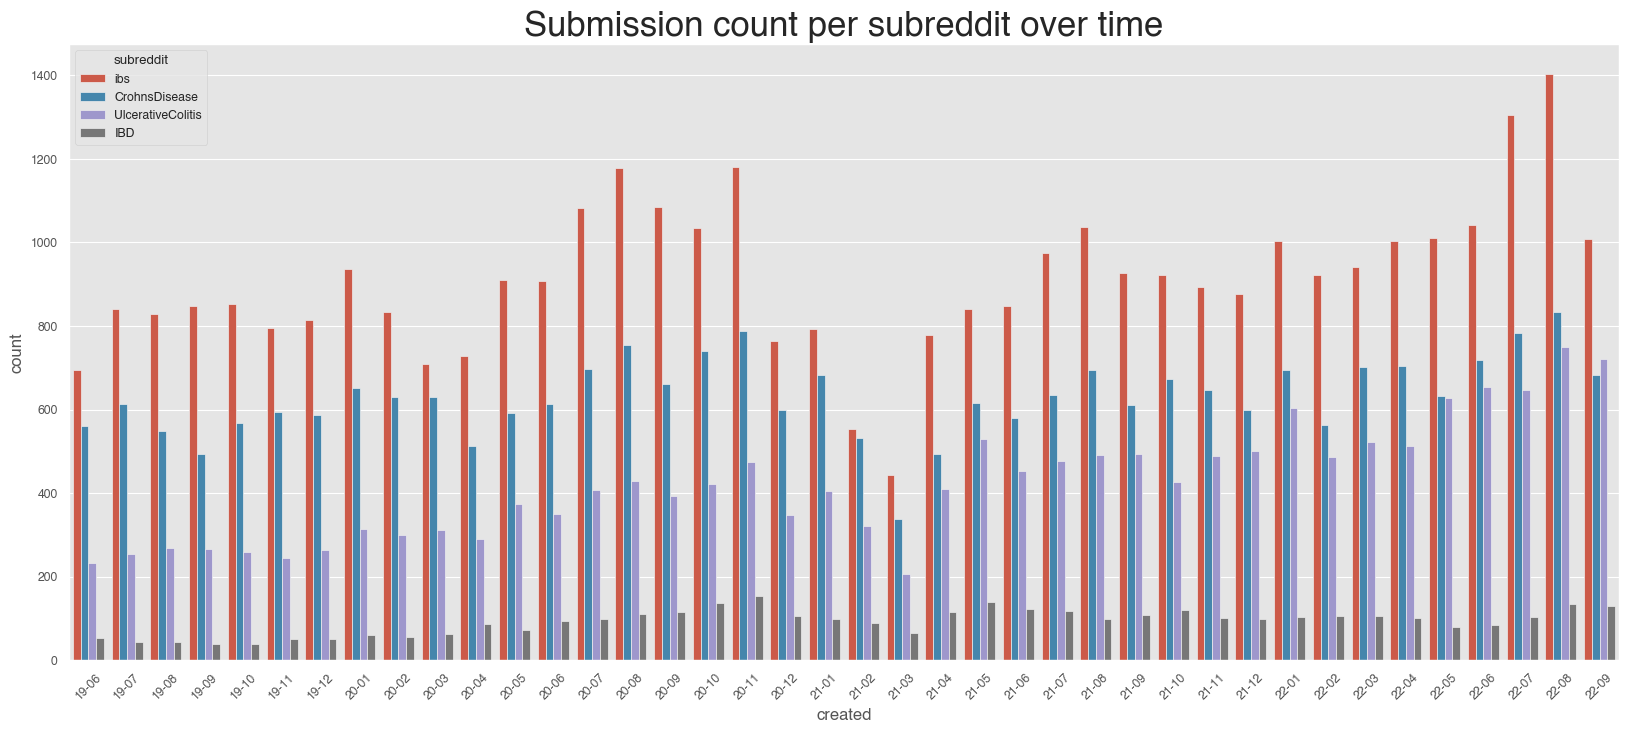

In [13]:
fig, ax = plt.subplots(figsize=(20,8), ncols=1, nrows=1)

plt.title('Submission count per subreddit over time', fontsize=25)
sns.countplot(data=df_c, x='created', hue='subreddit', ax=ax)
plt.xticks(rotation=45)

plt.show();

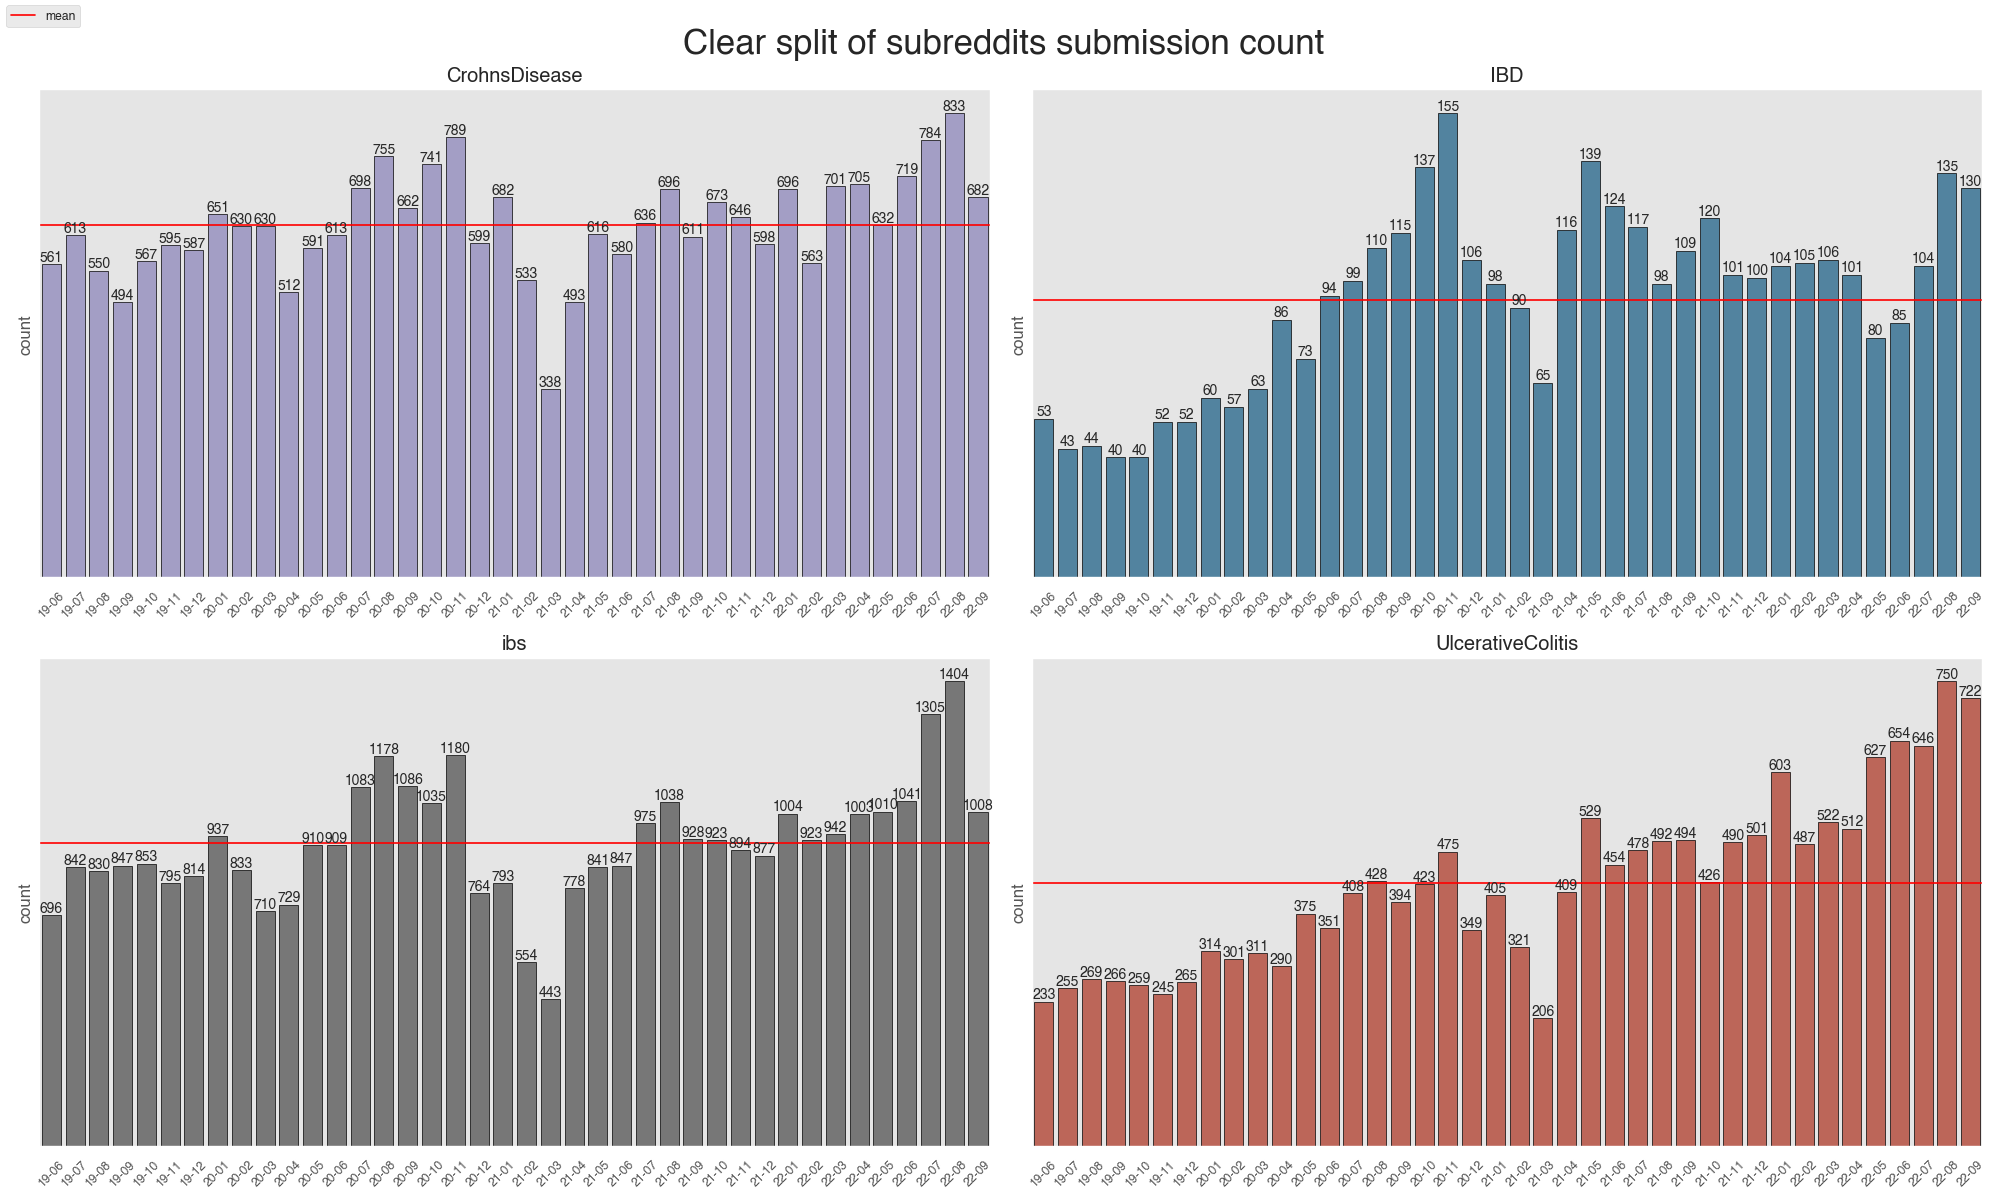

In [14]:
subs_per_month_per_subreddits = []
subs_per_month_per_subreddits.append(df_crohns['created'].dt.strftime('%y-%m').value_counts().sort_index().reset_index(name='counts'))
subs_per_month_per_subreddits.append(df_ibd['created'].dt.strftime('%y-%m').value_counts().sort_index().reset_index(name='counts'))
subs_per_month_per_subreddits.append(df_ibs['created'].dt.strftime('%y-%m').value_counts().sort_index().reset_index(name='counts'))
subs_per_month_per_subreddits.append(df_ulc['created'].dt.strftime('%y-%m').value_counts().sort_index().reset_index(name='counts'))

fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(figsize=(20,12), nrows=2, ncols=2)

plt.suptitle('Clear split of subreddits submission count', fontsize=25)

ax1 = sns.barplot(x='index', y='counts', data=subs_per_month_per_subreddits[0], edgecolor='black', color=colors[2], ax=ax1)
ax1.set_title('CrohnsDisease')
ax1.set_yticks([])
ax1.bar_label(ax1.containers[0])
ax1.set_ylabel('count')
ax1.set_xlabel('')
ax1.axhline(subs_per_month_per_subreddits[0].counts.mean(), color='r')
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

ax2 = sns.barplot(x='index', y='counts', data=subs_per_month_per_subreddits[1], edgecolor='black', color=colors[1], ax=ax2)
ax2.set_title('IBD')
ax2.set_yticks([])
ax2.bar_label(ax2.containers[0])
ax2.set_ylabel('count')
ax2.set_xlabel('')
ax2.axhline(subs_per_month_per_subreddits[1].counts.mean(), color='r')
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

ax3 = sns.barplot(x='index', y='counts', data=subs_per_month_per_subreddits[2], edgecolor='black', color=colors[3], ax=ax3)
ax3.set_title('ibs')
ax3.set_yticks([])
ax3.bar_label(ax3.containers[0])
ax3.set_ylabel('count')
ax3.set_xlabel('')
ax3.axhline(subs_per_month_per_subreddits[2].counts.mean(), color='r')
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)

ax4 = sns.barplot(x='index', y='counts', data=subs_per_month_per_subreddits[3], edgecolor='black', color=colors[0], ax=ax4)
ax4.set_title('UlcerativeColitis')
ax4.set_yticks([])
ax4.bar_label(ax4.containers[0])
ax4.set_ylabel('count')
ax4.set_xlabel('')
ax4.axhline(subs_per_month_per_subreddits[3].counts.mean(), color='r', label='mean')
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45)

fig.legend(loc='upper left')
fig.tight_layout()
plt.show()

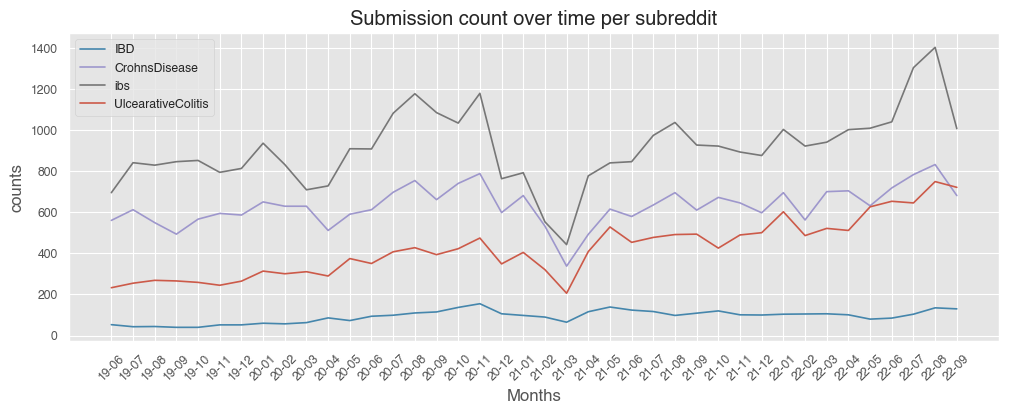

In [15]:
subs_per_month_per_subreddits = []
subs_per_month_per_subreddits.append(df_crohns['created'].dt.strftime('%y-%m').value_counts().sort_index().reset_index(name='counts'))
subs_per_month_per_subreddits.append(df_ibd['created'].dt.strftime('%y-%m').value_counts().sort_index().reset_index(name='counts'))
subs_per_month_per_subreddits.append(df_ibs['created'].dt.strftime('%y-%m').value_counts().sort_index().reset_index(name='counts'))
subs_per_month_per_subreddits.append(df_ulc['created'].dt.strftime('%y-%m').value_counts().sort_index().reset_index(name='counts'))

plt.figure(figsize=(12, 4))
plt.title('Submission count over time per subreddit')

sns.lineplot(x='index', y='counts', data=subs_per_month_per_subreddits[1], label='IBD', color=colors[1]);
plt.xticks(rotation = 45)

sns.lineplot(x='index', y='counts', data=subs_per_month_per_subreddits[0], label='CrohnsDisease', color=colors[2]);
plt.xticks(rotation = 45)

sns.lineplot(x='index', y='counts', data=subs_per_month_per_subreddits[2], label='ibs', color=colors[3]);
plt.xticks(rotation = 45)

sns.lineplot(x='index', y='counts', data=subs_per_month_per_subreddits[3], label='UlcearativeColitis', color=colors[0]);
plt.xticks(rotation = 45)

plt.xlabel('Months')
plt.show();


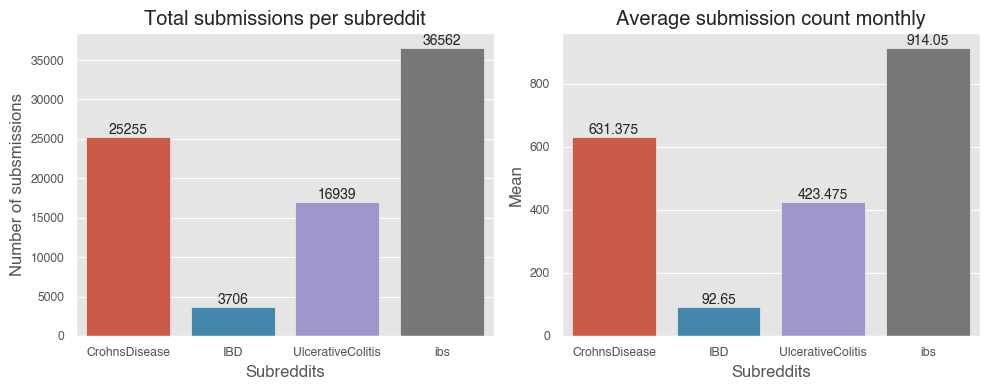

In [16]:
fig, [ax1, ax2] = plt.subplots(figsize=(10,4), nrows=1, ncols=2)
sns.barplot(x=subreddits, y=df_submissions.subreddit.value_counts().sort_index(), ax=ax1)
ax1.set_title('Total submissions per subreddit')
ax1.set_ylabel('Number of subsmissions')
ax1.bar_label(ax1.containers[0])
ax1.set_xlabel('Subreddits')

sns.barplot(x=subreddits, y=df_submissions.subreddit.value_counts().sort_index() / len(df_submissions['created'].dt.strftime('%y-%m').value_counts()), ax=ax2)
ax2.set_title('Average submission count monthly')
ax2.set_ylabel('Mean')
ax2.set_xlabel('Subreddits')
ax2.bar_label(ax2.containers[0])

plt.tight_layout()
plt.show();

### Comments analysis 

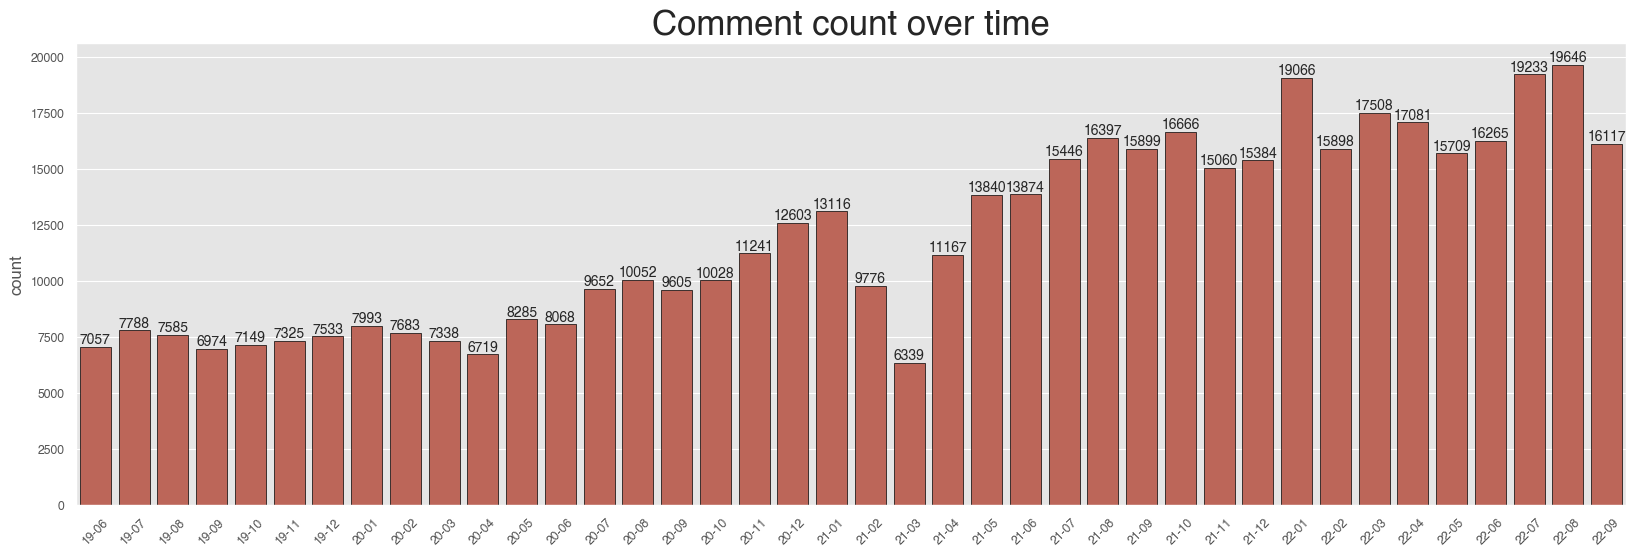

In [17]:
comments_per_month = df_comments['created'].dt.strftime('%y-%m').value_counts().sort_index().reset_index(name='counts')

plt.figure(figsize=(20,6))
ax = sns.barplot(x='index', y='counts', data=comments_per_month, edgecolor='black', color=colors[0])
plt.title('Comment count over time', fontsize=25)
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.xticks(rotation=45)

plt.show()

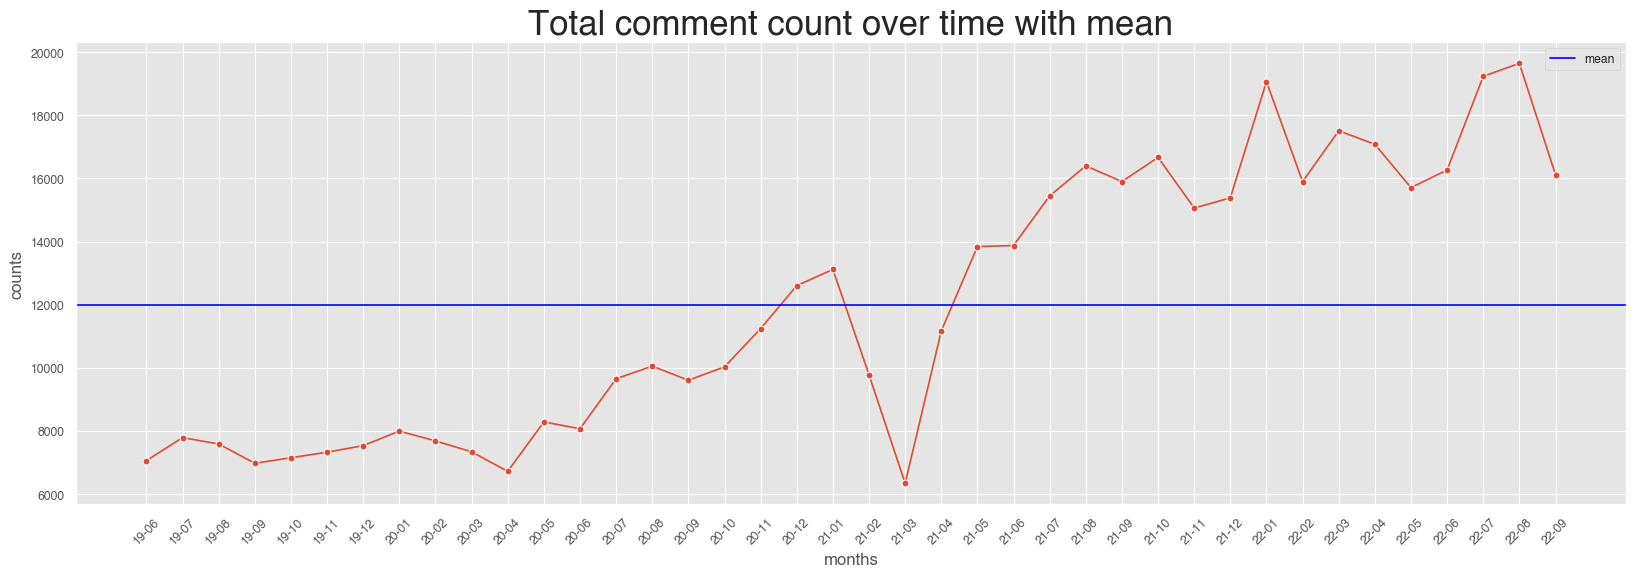

In [18]:
comments_per_month = df_comments['created'].dt.strftime('%y-%m').value_counts().sort_index().reset_index(name='counts')

comm_per_month_df = pd.DataFrame(comments_per_month)

comm_per_month_df = comm_per_month_df.rename(columns={'index': 'months'}).reset_index()

plt.figure(figsize=(20, 6))
plt.title('Total comment count over time with mean', fontsize=25)
sns.lineplot(x=comm_per_month_df.months, y=comm_per_month_df.counts, marker='o', markersize=5);
plt.xticks(rotation = 45)
plt.axhline(comm_per_month_df.counts.mean(), color='b', label='mean')

plt.legend()
plt.show();

### Comment analysis per subreddit <a class='anchor' id='comm-sr'>

In [19]:
df_c_c = df_comments.copy()
df_c_c.created = df_c_c.created.apply(lambda x: x.strftime('%y-%m'))
df_c_c.sort_values('created', inplace=True)

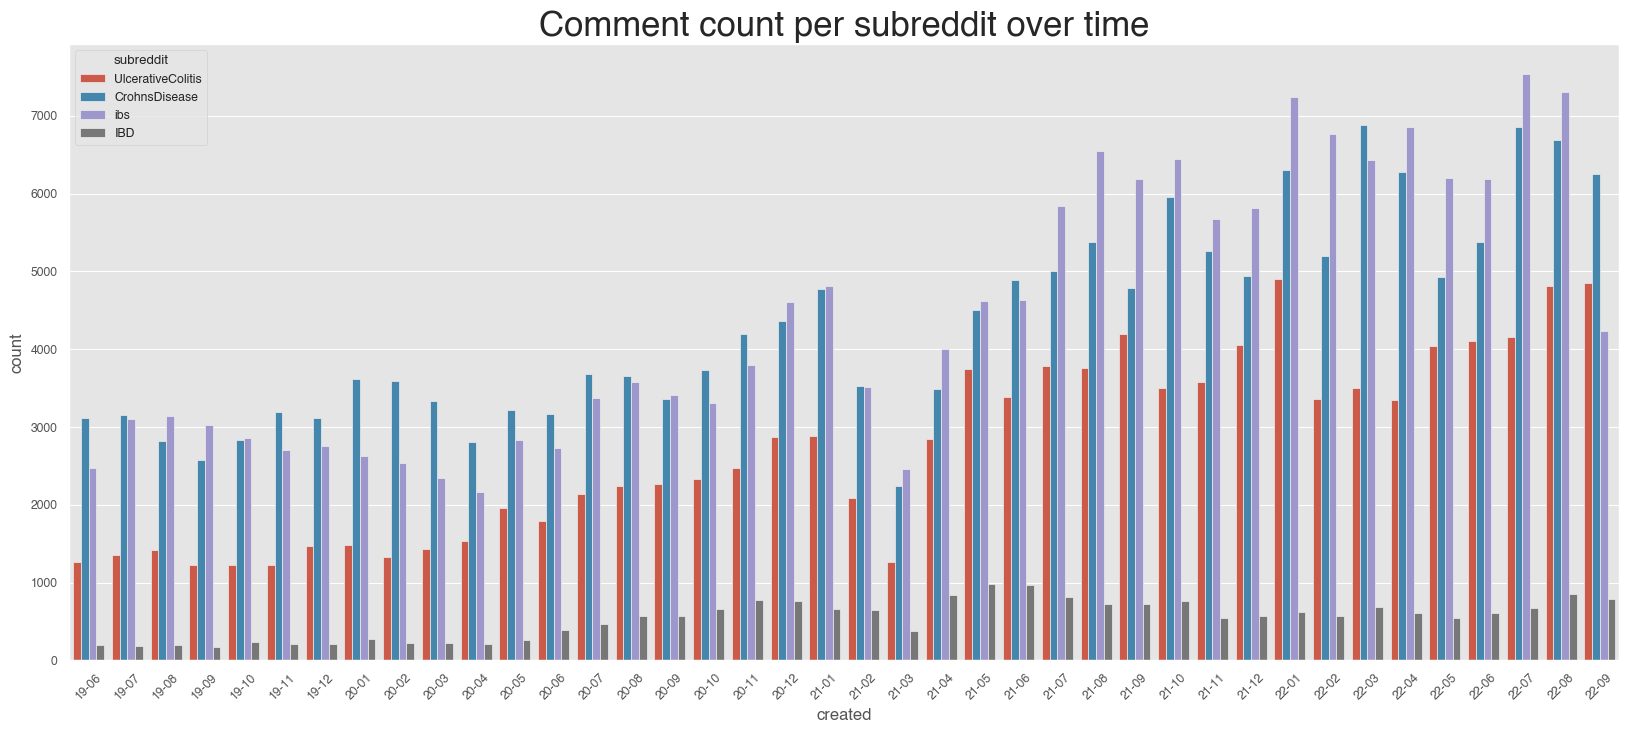

In [20]:
fig, ax = plt.subplots(figsize=(20,8))

plt.title('Comment count per subreddit over time', fontsize=25)
sns.countplot(data=df_c_c, hue='subreddit', x='created')
plt.xticks(rotation=45)

plt.show();

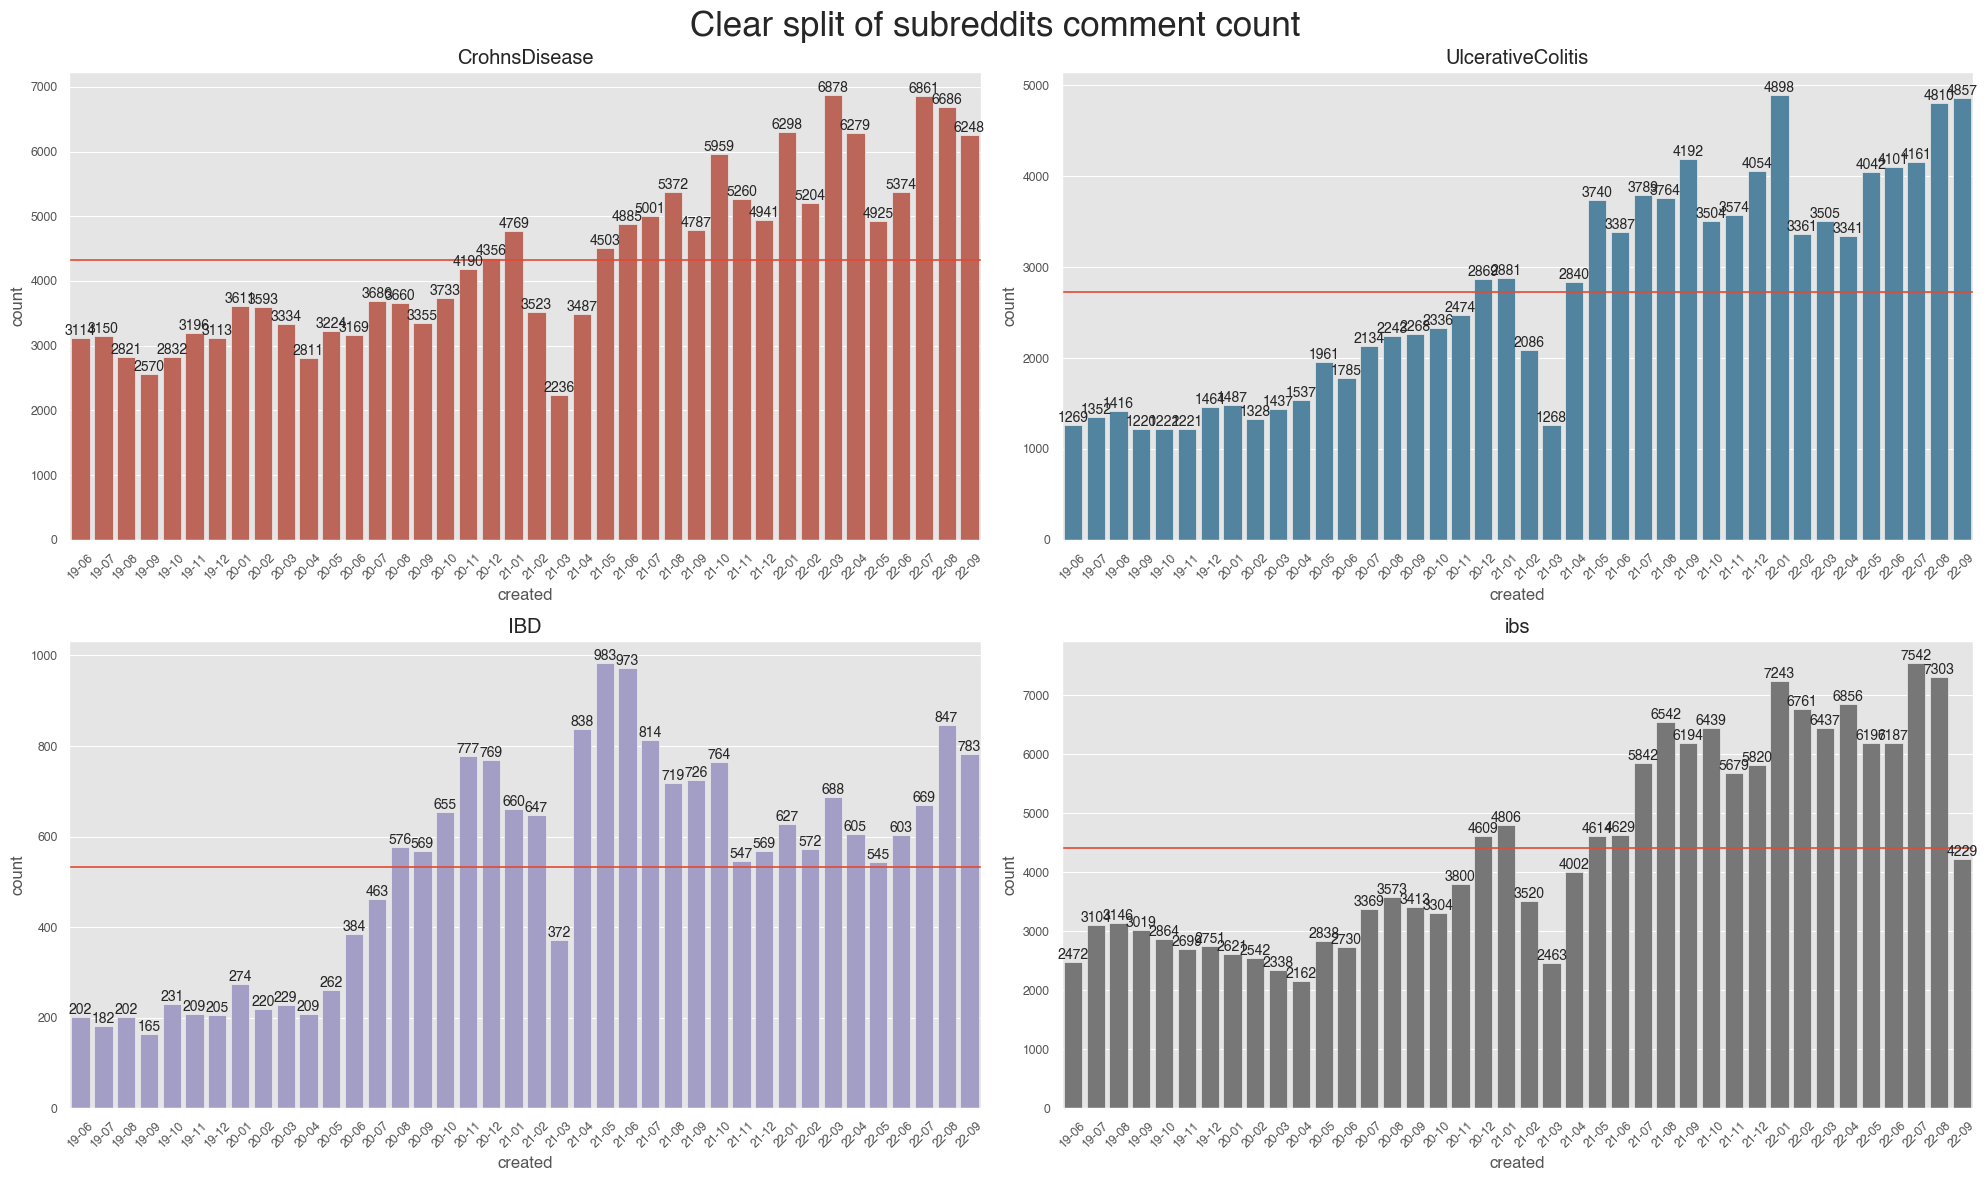

In [21]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(figsize=(20,12), nrows=2, ncols=2)

plt.suptitle('Clear split of subreddits comment count', fontsize=25)

comm_crohn = df_c_c[df_c_c['subreddit'] == 'CrohnsDisease']
sns.countplot(data=comm_crohn, x='created', ax=ax1, color=colors[0])
ax1.axhline(mean(df_c_c[df_c_c['subreddit'] == 'CrohnsDisease'].groupby('created').count().id))
ax1.set_title('CrohnsDisease')
ax1.bar_label(ax1.containers[0])
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

comm_ulc = df_c_c[df_c_c['subreddit'] == 'UlcerativeColitis']
sns.countplot(data=comm_ulc, x='created', ax=ax2, color=colors[1])
ax2.axhline(mean(df_c_c[df_c_c['subreddit'] == 'UlcerativeColitis'].groupby('created').count().id))
ax2.set_title('UlcerativeColitis')
ax2.bar_label(ax2.containers[0])
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

comm_ibd = df_c_c[df_c_c['subreddit'] == 'IBD']
sns.countplot(data=comm_ibd, x='created', ax=ax3, color=colors[2])
ax3.axhline(mean(df_c_c[df_c_c['subreddit'] == 'IBD'].groupby('created').count().id))
ax3.set_title('IBD')
ax3.bar_label(ax3.containers[0])
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)

comm_ibs = df_c_c[df_c_c['subreddit'] == 'ibs']
sns.countplot(data=comm_ibs, x='created', ax=ax4, color=colors[3])
ax4.axhline(mean(df_c_c[df_c_c['subreddit'] == 'ibs'].groupby('created').count().id))
ax4.set_title('ibs')
ax4.bar_label(ax4.containers[0])
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45)

fig.tight_layout()
plt.show();

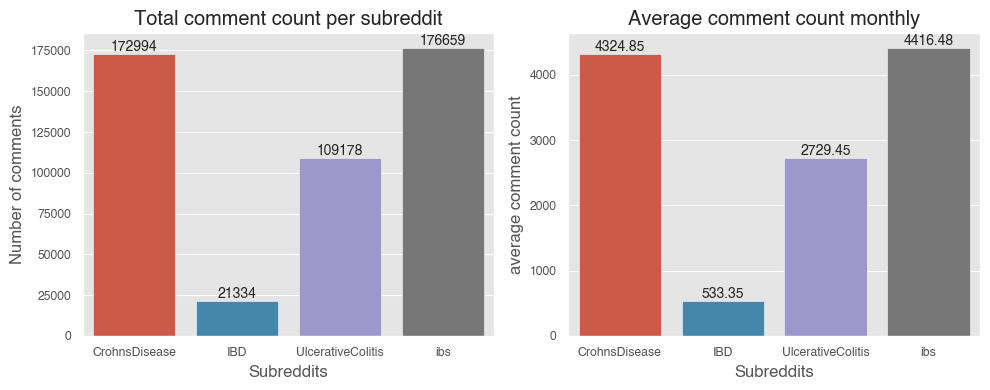

In [22]:
fig, [ax1, ax2] = plt.subplots(figsize=(10,4), ncols=2, nrows=1)

sns.barplot(x=subreddits, y=df_comments.groupby('subreddit')['id'].count().sort_index(), ax=ax1)

ax1.set_title('Total comment count per subreddit')
ax1.set_ylabel('Number of comments')
ax1.set_xlabel('Subreddits')
ax1.bar_label(ax1.containers[0])

sns.barplot(x=subreddits, y=df_comments.subreddit.value_counts().sort_index() / len(df_comments['created'].dt.strftime('%y-%m').value_counts()), ax=ax2)
ax2.set_title('Average comment count monthly')
ax2.set_xlabel('Subreddits')
ax2.set_ylabel('average comment count')
ax2.bar_label(ax2.containers[0])

plt.tight_layout()
plt.show();

### Take a look at the users 

In [23]:
df_sub_author = df_submissions[df_submissions.author.notna()]
df_comm_author = df_comments[df_comments.author.notna()]

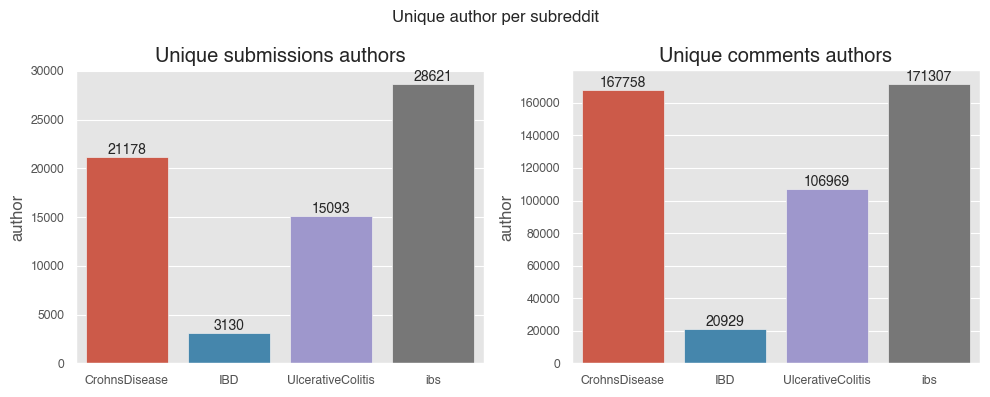

In [24]:
fig, [ax1, ax2] = plt.subplots(figsize=(10,4), ncols=2, nrows=1)

plt.suptitle('Unique author per subreddit')

ax1.set_title('Unique submissions authors')
sns.barplot(x=subreddits, y=df_sub_author.groupby('subreddit').count().author, ax=ax1)
ax1.bar_label(ax1.containers[0])

ax2.set_title('Unique comments authors')
sns.barplot(x=subreddits, y=df_comm_author.groupby('subreddit').count().author, ax=ax2)
ax2.bar_label(ax2.containers[0])

plt.tight_layout()
plt.show();

In [25]:
sub_crohn_users = df_sub_author[df_sub_author['subreddit'] == 'CrohnsDisease'].groupby('author').count().sort_values('created', ascending=False).iloc[0:20].reset_index()
sub_ibs_users = df_sub_author[df_sub_author['subreddit'] == 'ibs'].groupby('author').count().sort_values('created', ascending=False).iloc[0:20].reset_index()
sub_ibd_users = df_sub_author[df_sub_author['subreddit'] == 'IBD'].groupby('author').count().sort_values('created', ascending=False).iloc[0:20].reset_index()
sub_ulc_users = df_sub_author[df_sub_author['subreddit'] == 'UlcerativeColitis'].groupby('author').count().sort_values('created', ascending=False).iloc[0:20].reset_index()

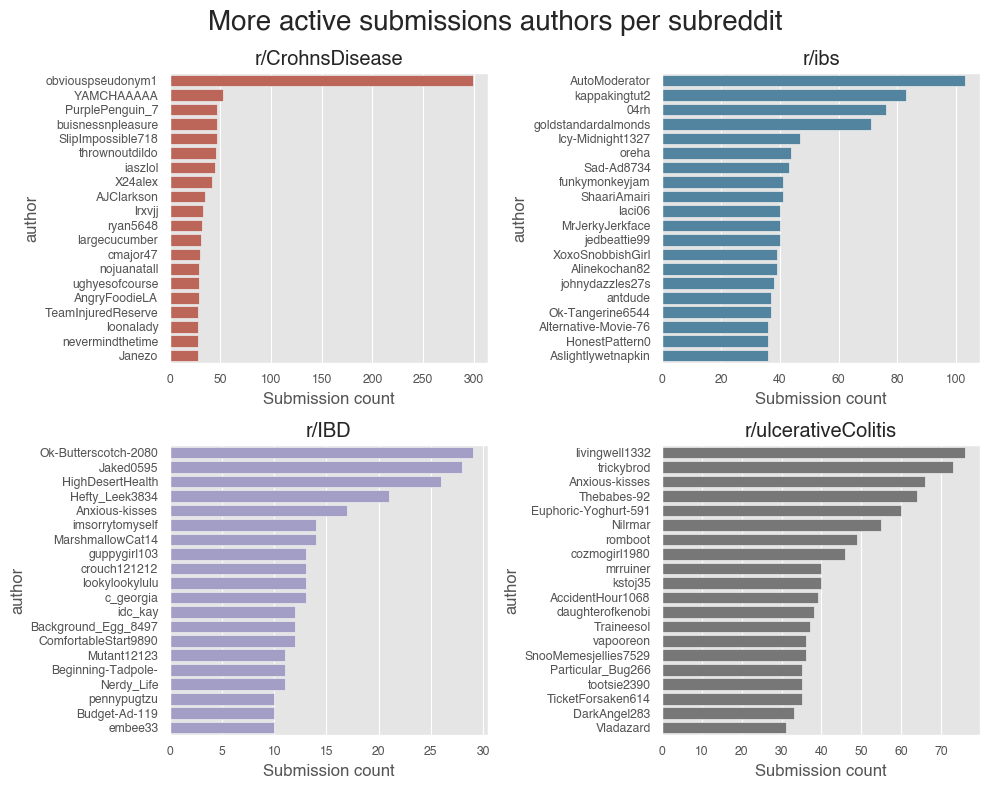

In [26]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(figsize=(10, 8), ncols=2, nrows=2)

plt.suptitle('More active submissions authors per subreddit', fontsize=20)

sns.barplot(y=sub_crohn_users.author, x=sub_crohn_users.created, ax=ax1, orient='h', color=colors[0])
ax1.set_title('r/CrohnsDisease')
ax1.set_xlabel('Submission count')

sns.barplot(y=sub_ibs_users.author, x=sub_ibs_users.created, ax=ax2, orient='h', color=colors[1])
ax2.set_title('r/ibs')
ax2.set_xlabel('Submission count')

sns.barplot(y=sub_ibd_users.author, x=sub_ibd_users.created, ax=ax3, orient='h', color=colors[2])
ax3.set_title('r/IBD')
ax3.set_xlabel('Submission count')

sns.barplot(y=sub_ulc_users.author, x=sub_ulc_users.created, ax=ax4, orient='h', color=colors[3])
ax4.set_title('r/ulcerativeColitis')
ax4.set_xlabel('Submission count')

plt.tight_layout()
plt.show();

In [27]:
comm_crohn_users = df_comm_author[df_comm_author['subreddit'] == 'CrohnsDisease'].groupby('author').count().sort_values('created', ascending=False).iloc[0:20].reset_index()
comm_ibs_users = df_comm_author[df_comm_author['subreddit'] == 'ibs'].groupby('author').count().sort_values('created', ascending=False).iloc[0:20].reset_index()
comm_ibd_users = df_comm_author[df_comm_author['subreddit'] == 'IBD'].groupby('author').count().sort_values('created', ascending=False).iloc[0:20].reset_index()
comm_ulc_users = df_comm_author[df_comm_author['subreddit'] == 'UlcerativeColitis'].groupby('author').count().sort_values('created', ascending=False).iloc[0:20].reset_index()

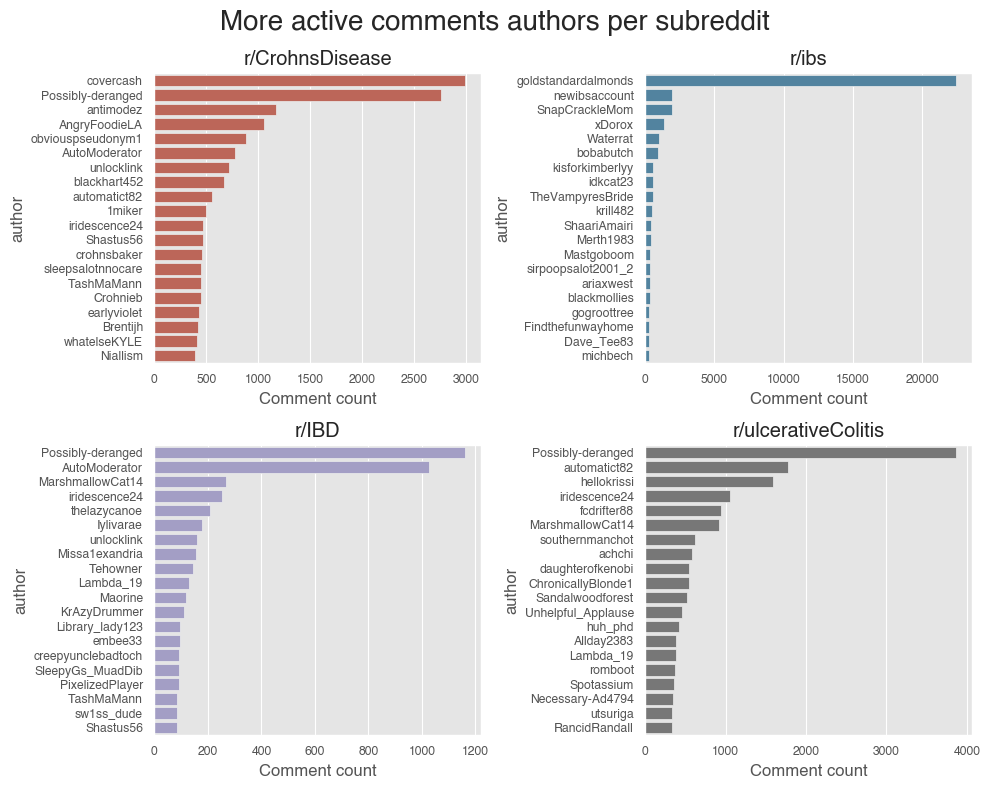

In [28]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(figsize=(10, 8), ncols=2, nrows=2)

plt.suptitle('More active comments authors per subreddit', fontsize=20)

sns.barplot(y=comm_crohn_users.author, x=comm_crohn_users.created, ax=ax1, orient='h', color=colors[0])
ax1.set_title('r/CrohnsDisease')
ax1.set_xlabel('Comment count')

sns.barplot(y=comm_ibs_users.author, x=comm_ibs_users.created, ax=ax2, orient='h', color=colors[1])
ax2.set_title('r/ibs')
ax2.set_xlabel('Comment count')

sns.barplot(y=comm_ibd_users.author, x=comm_ibd_users.created, ax=ax3, orient='h', color=colors[2])
ax3.set_title('r/IBD')
ax3.set_xlabel('Comment count')

sns.barplot(y=comm_ulc_users.author, x=comm_ulc_users.created, ax=ax4, orient='h', color=colors[3])
ax4.set_title('r/ulcerativeColitis')
ax4.set_xlabel('Comment count')

plt.tight_layout()
plt.show();

## Covid Related Posts 

In [29]:
covid_keywords = [
    "Pandemic",
    "pandemic",
    "coronavirus" ,
    "CORONAVIRUS",
    "Coronavirus",
    "COVID-19",
    "COVID19",
    "COVID",
    "COVID 19",
    "covid-19",
    "covid19",
    "covid",
    "covid 19",
    "Covid-19",
    "Covid19",
    "Covid",
    "Covid 19",
    "Vaccine",
    "vaccine"
    "SARS-COV-2",
    "SARS COV-2",
    "SARS-COV2",
    "SARS-COV 2",
    "SARS COV"
]

In [30]:
pattern = '|'.join([f'{keyword}' for keyword in covid_keywords])

### Covid related submissions

In [31]:
df_filtered_covid = df_submissions[df_submissions.title_and_body.str.contains(pattern)].copy()

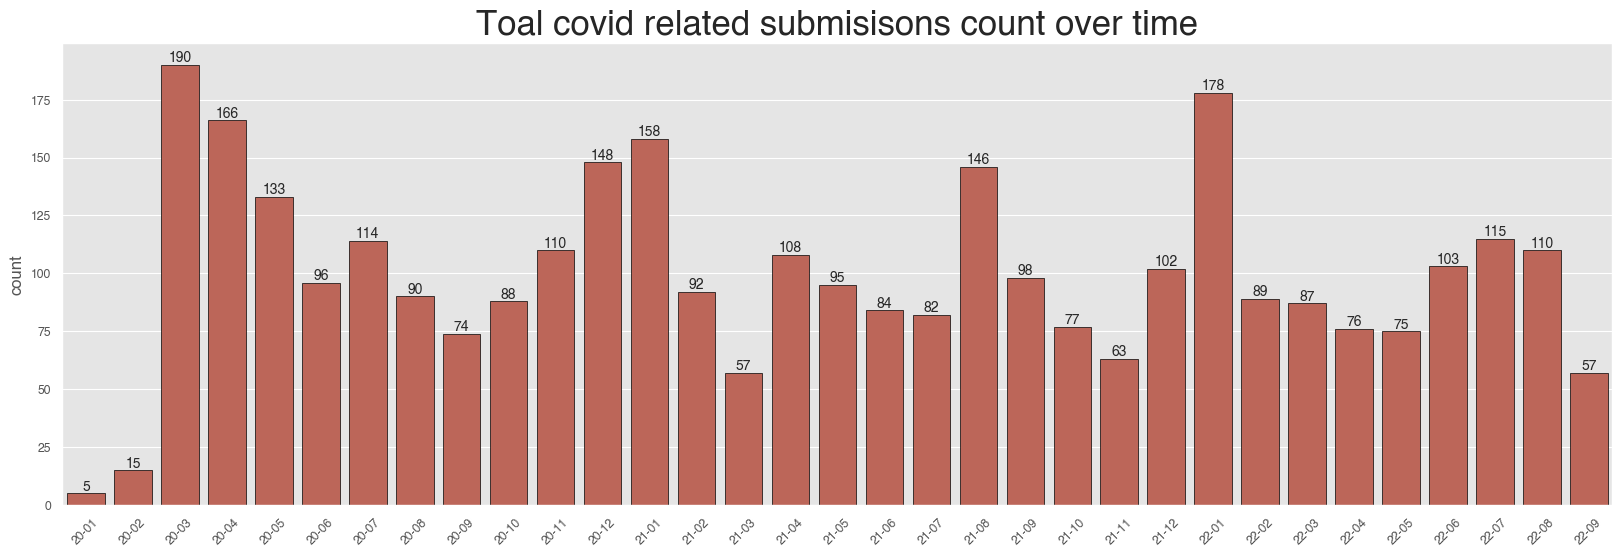

In [33]:
covid_submissions_per_month = df_filtered_covid['created'].dt.strftime('%y-%m').value_counts().sort_index().reset_index(name='counts')

plt.figure(figsize=(20,6))

ax = sns.barplot(x='index', y='counts', data=covid_submissions_per_month, edgecolor='black', color=colors[0])
plt.title('Toal covid related submisisons count over time', fontsize=25)
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.xticks(rotation=45)

plt.show();

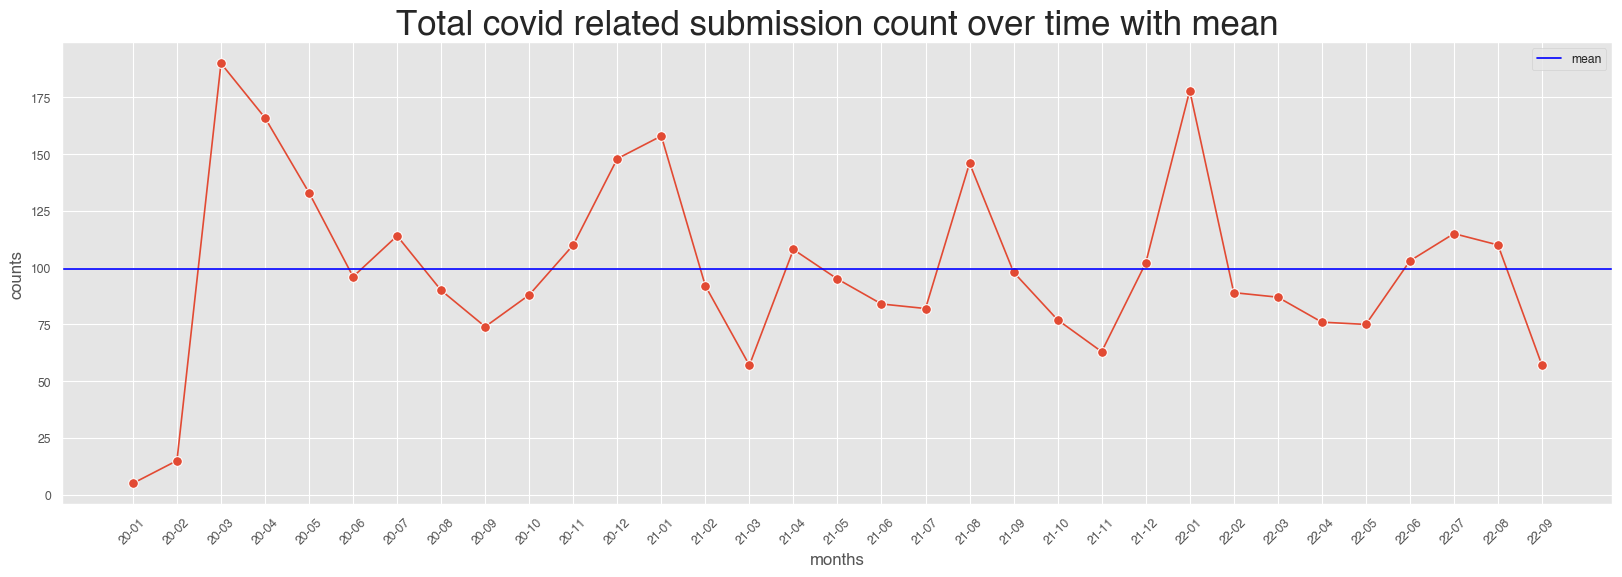

In [34]:
cov_submissions_per_month = df_filtered_covid['created'].dt.strftime('%y-%m').value_counts().sort_index().reset_index(name='counts')

cov_subs_per_month_df = pd.DataFrame(cov_submissions_per_month)

cov_subs_per_month_df = cov_subs_per_month_df.rename(columns={'index': 'months'}).reset_index()

plt.figure(figsize=(20, 6))
plt.title('Total covid related submission count over time with mean', fontsize=25)
sns.lineplot(x=cov_subs_per_month_df.months, y=cov_subs_per_month_df.counts, marker='o', markersize=7);
plt.xticks(rotation = 45)
plt.axhline(cov_subs_per_month_df.counts.mean(), color='b', label='mean')

plt.legend()
plt.show();

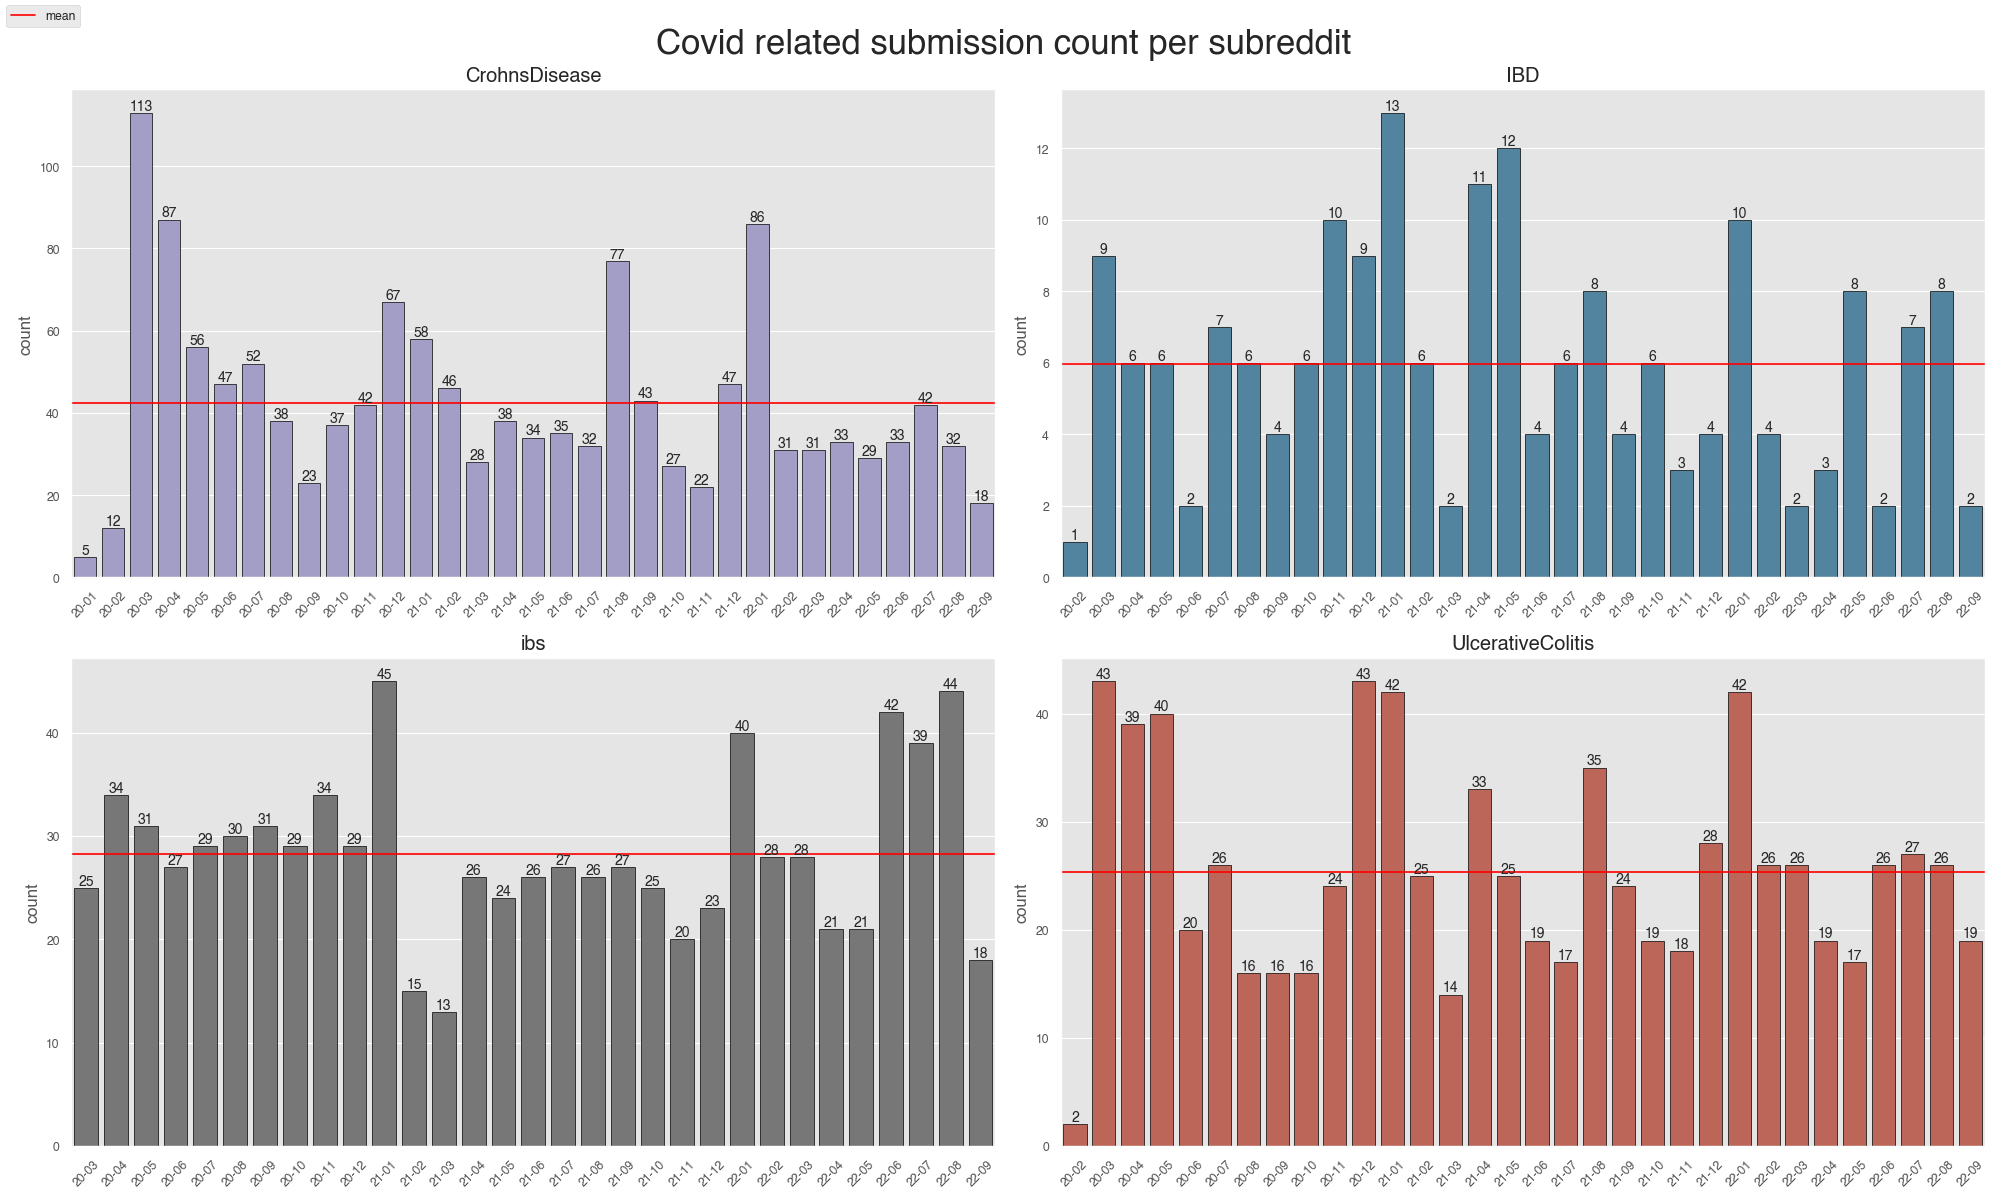

In [35]:
df_filtered_covid.sort_values('created', inplace=True)
df_crohns_filt = df_filtered_covid[df_filtered_covid['subreddit'] == 'CrohnsDisease']
df_ibd_filt = df_filtered_covid[df_filtered_covid['subreddit'] == 'IBD']
df_ibs_filt = df_filtered_covid[df_filtered_covid['subreddit'] == 'ibs']
df_ulc_filt = df_filtered_covid[df_filtered_covid['subreddit'] == 'UlcerativeColitis']

cov_subs_per_month_per_subreddits = []
cov_subs_per_month_per_subreddits.append(df_crohns_filt['created'].dt.strftime('%y-%m').value_counts().sort_index().reset_index(name='counts'))
cov_subs_per_month_per_subreddits.append(df_ibd_filt['created'].dt.strftime('%y-%m').value_counts().sort_index().reset_index(name='counts'))
cov_subs_per_month_per_subreddits.append(df_ibs_filt['created'].dt.strftime('%y-%m').value_counts().sort_index().reset_index(name='counts'))
cov_subs_per_month_per_subreddits.append(df_ulc_filt['created'].dt.strftime('%y-%m').value_counts().sort_index().reset_index(name='counts'))

fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(figsize=(20,12), nrows=2, ncols=2)

plt.suptitle('Covid related submission count per subreddit', fontsize=25)

ax1 = sns.barplot(x='index', y='counts', data=cov_subs_per_month_per_subreddits[0], edgecolor='black', color=colors[2], ax=ax1)
ax1.set_title('CrohnsDisease')
ax1.bar_label(ax1.containers[0])
ax1.set_ylabel('count')
ax1.set_xlabel('')
ax1.axhline(cov_subs_per_month_per_subreddits[0].counts.mean(), color='r')
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

ax2 = sns.barplot(x='index', y='counts', data=cov_subs_per_month_per_subreddits[1], edgecolor='black', color=colors[1], ax=ax2)
ax2.set_title('IBD')
ax2.bar_label(ax2.containers[0])
ax2.set_ylabel('count')
ax2.set_xlabel('')
ax2.axhline(cov_subs_per_month_per_subreddits[1].counts.mean(), color='r')
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

ax3 = sns.barplot(x='index', y='counts', data=cov_subs_per_month_per_subreddits[2], edgecolor='black', color=colors[3], ax=ax3)
ax3.set_title('ibs')
ax3.bar_label(ax3.containers[0])
ax3.set_ylabel('count')
ax3.set_xlabel('')
ax3.axhline(cov_subs_per_month_per_subreddits[2].counts.mean(), color='r')
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)

ax4 = sns.barplot(x='index', y='counts', data=cov_subs_per_month_per_subreddits[3], edgecolor='black', color=colors[0], ax=ax4)
ax4.set_title('UlcerativeColitis')
ax4.bar_label(ax4.containers[0])
ax4.set_ylabel('count')
ax4.set_xlabel('')
ax4.axhline(cov_subs_per_month_per_subreddits[3].counts.mean(), color='r', label='mean')
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45)

fig.legend(loc='upper left')
fig.tight_layout()
plt.show()

In [36]:
df_c_covid = df_filtered_covid.copy()
df_c_covid.created = df_c_covid.created.apply(lambda x: x.strftime('%y-%m')) 
df_c_covid.sort_values('created', inplace=True)

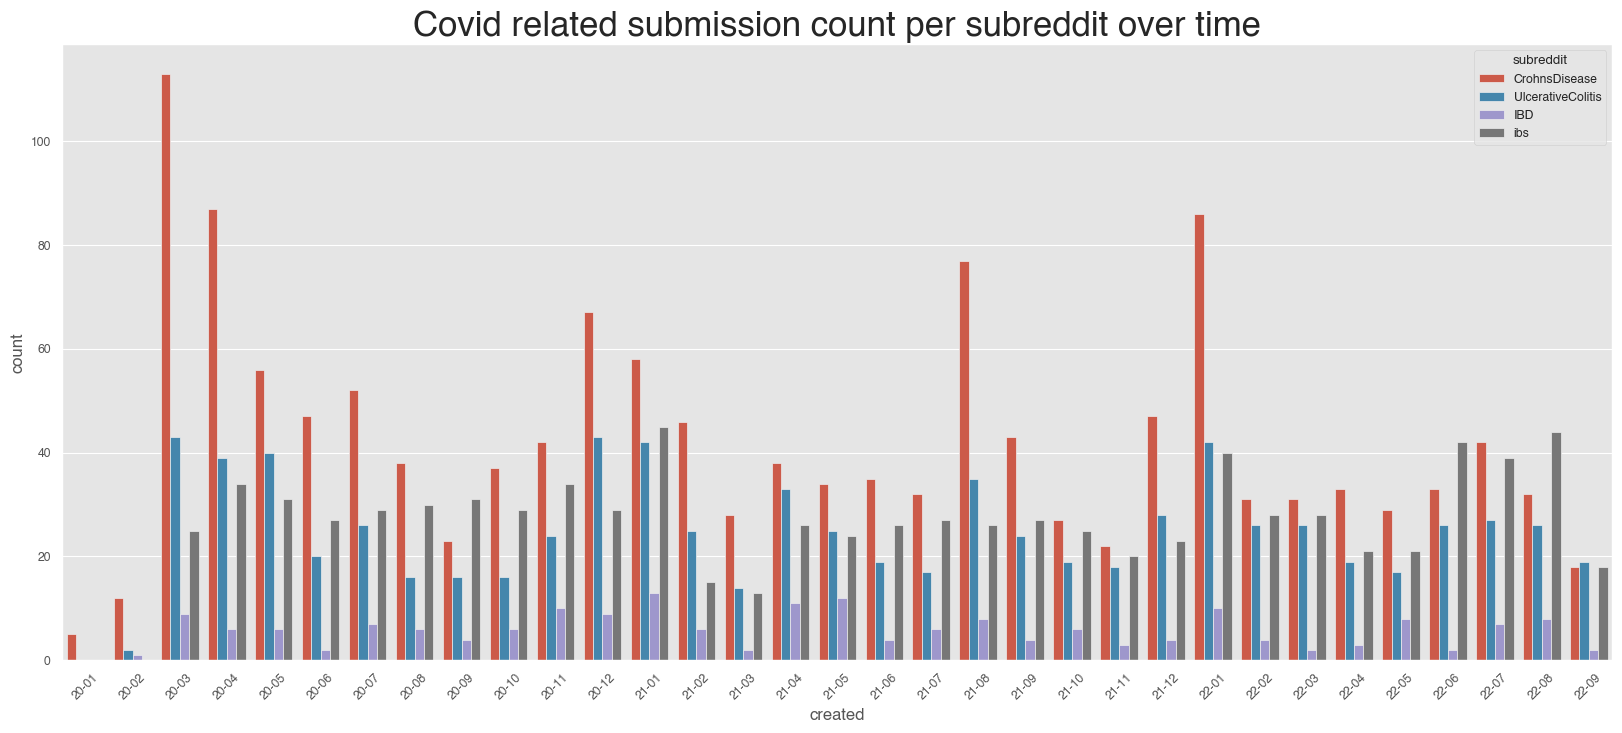

In [37]:
fig, ax = plt.subplots(figsize=(20,8), ncols=1, nrows=1)

plt.title('Covid related submission count per subreddit over time', fontsize=25)
sns.countplot(data=df_c_covid, x='created', hue='subreddit', ax=ax)
plt.xticks(rotation=45)

plt.show();

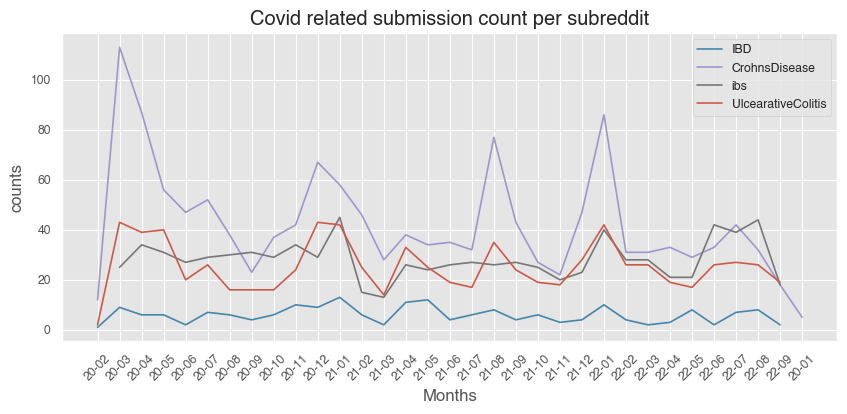

In [38]:
cov_subs_per_month_per_subreddits = []
cov_subs_per_month_per_subreddits.append(df_crohns_filt['created'].dt.strftime('%y-%m').value_counts().sort_index().reset_index(name='counts'))
cov_subs_per_month_per_subreddits.append(df_ibd_filt['created'].dt.strftime('%y-%m').value_counts().sort_index().reset_index(name='counts'))
cov_subs_per_month_per_subreddits.append(df_ibs_filt['created'].dt.strftime('%y-%m').value_counts().sort_index().reset_index(name='counts'))
cov_subs_per_month_per_subreddits.append(df_ulc_filt['created'].dt.strftime('%y-%m').value_counts().sort_index().reset_index(name='counts'))

plt.figure(figsize=(10, 4))
plt.title('Covid related submission count per subreddit')

sns.lineplot(x='index', y='counts', data=cov_subs_per_month_per_subreddits[1], label='IBD', color=colors[1]);
plt.xticks(rotation = 45)

sns.lineplot(x='index', y='counts', data=cov_subs_per_month_per_subreddits[0], label='CrohnsDisease', color=colors[2]);
plt.xticks(rotation = 45)

sns.lineplot(x='index', y='counts', data=cov_subs_per_month_per_subreddits[2], label='ibs', color=colors[3]);
plt.xticks(rotation = 45)

sns.lineplot(x='index', y='counts', data=cov_subs_per_month_per_subreddits[3], label='UlcearativeColitis', color=colors[0]);
plt.xticks(rotation = 45)

plt.xlabel('Months')
plt.show();

### Covid related comments

In [74]:
#df_comments = df_comments[df_comments['body'].notna()]
#df_comments = df_comments[df_comments['body'] != '']
df_comm_filtered = df_comments[df_comments.body.str.contains(pattern)].copy()

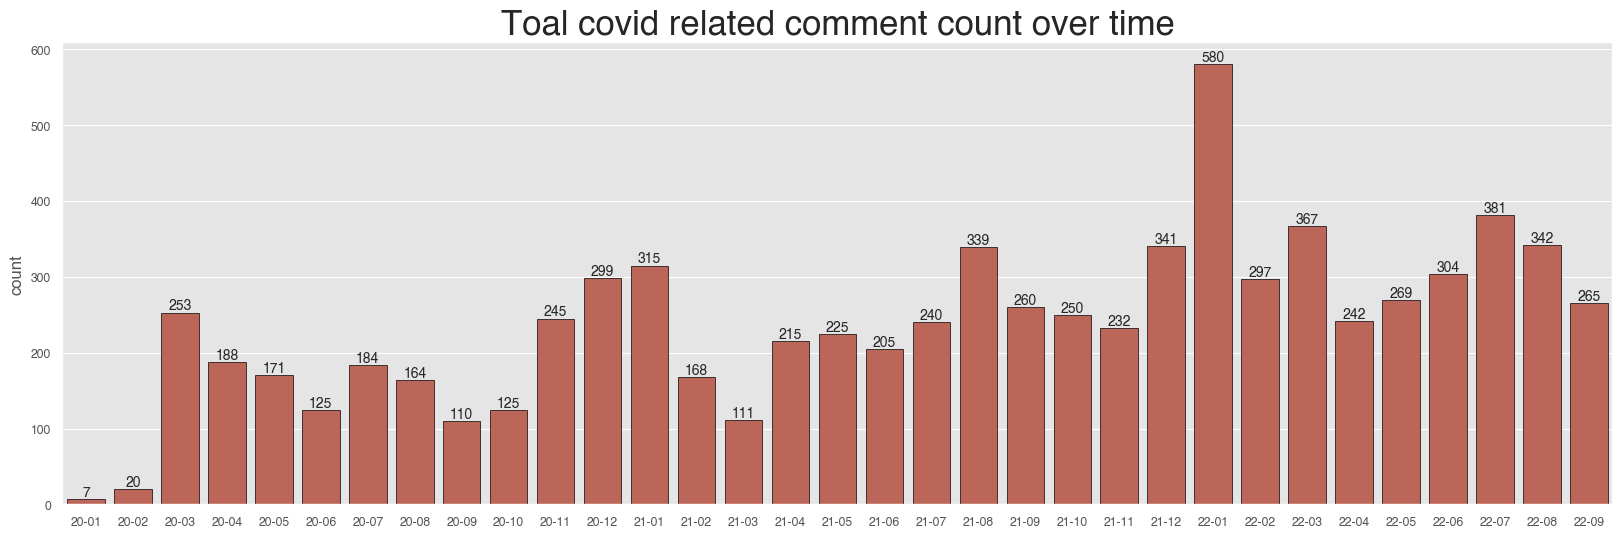

In [76]:
covid_comments_per_month = df_comm_filtered['created'].dt.strftime('%y-%m').value_counts().sort_index().reset_index(name='counts')

plt.figure(figsize=(20,6))
ax = sns.barplot(x='index', y='counts', data=covid_comments_per_month, edgecolor='black', color=colors[0])
plt.title('Toal covid related comment count over time', fontsize=25)
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')

plt.show();

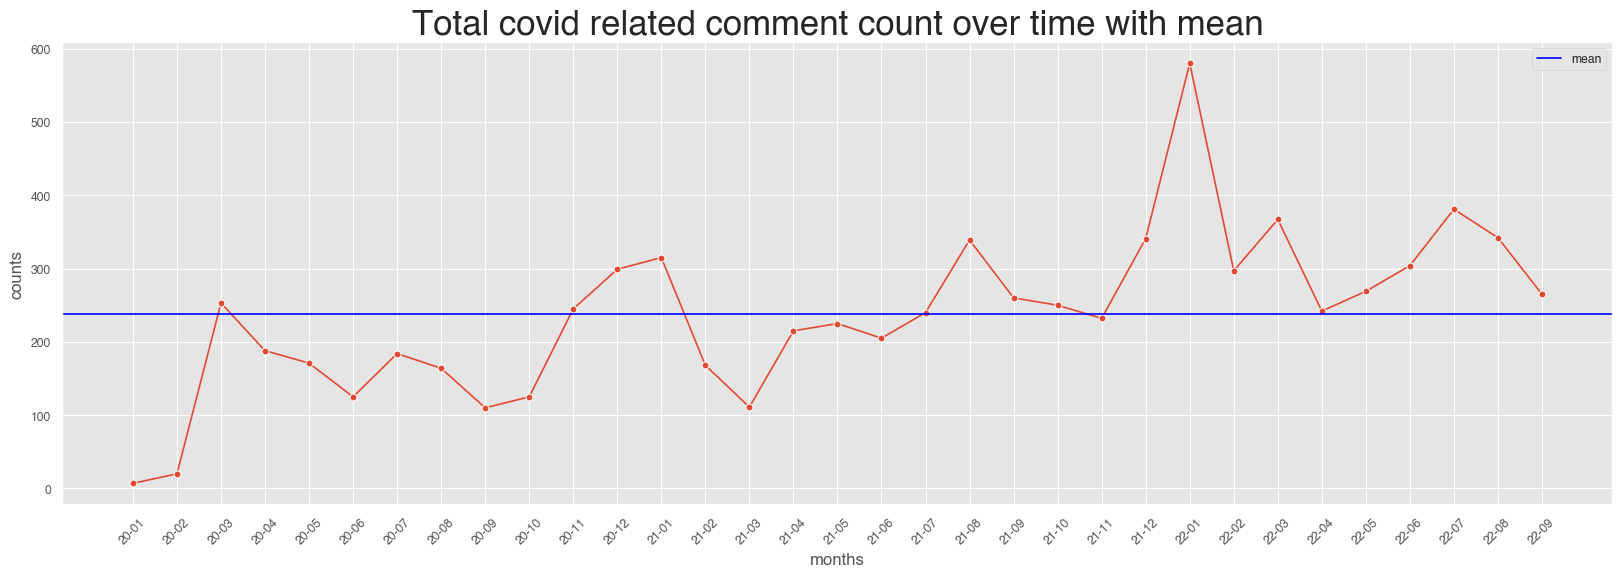

In [77]:
cov_comments_per_month = df_comm_filtered['created'].dt.strftime('%y-%m').value_counts().sort_index().reset_index(name='counts')

cov_comm_per_month_df = pd.DataFrame(cov_comments_per_month)

cov_comm_per_month_df = cov_comm_per_month_df.rename(columns={'index': 'months'}).reset_index()

plt.figure(figsize=(20, 6))
plt.title('Total covid related comment count over time with mean', fontsize=25)
sns.lineplot(x=cov_comm_per_month_df.months, y=cov_comm_per_month_df.counts, marker='o', markersize=5);
plt.xticks(rotation = 45)
plt.axhline(cov_comm_per_month_df.counts.mean(), color='b', label='mean')

plt.legend()
plt.show();

In [42]:
df_c_comm_covid = df_comm_filtered.copy()
df_c_comm_covid.created = df_c_comm_covid.created.apply(lambda x: x.strftime('%y-%m'))

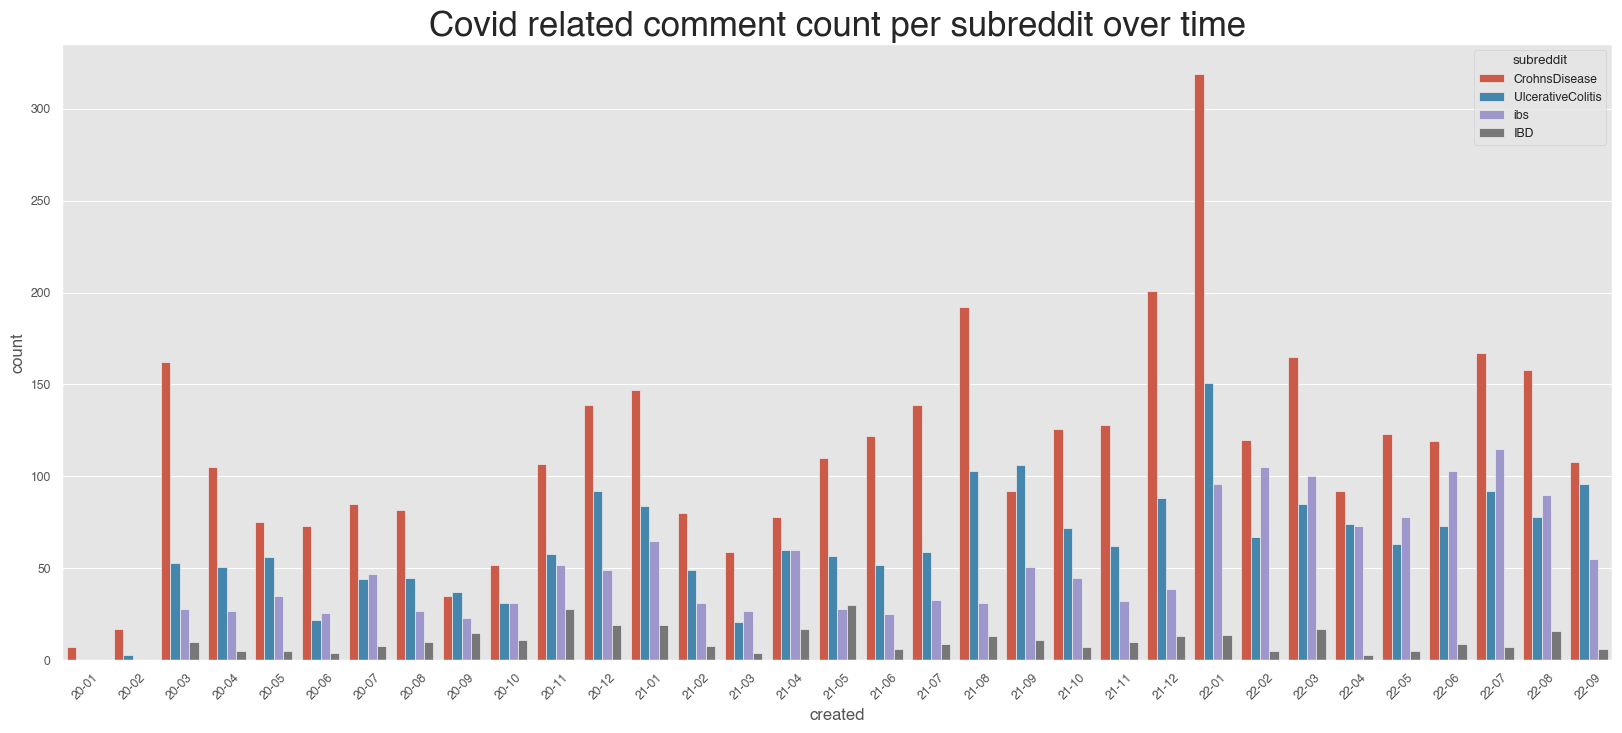

In [43]:
df_c_comm_covid.sort_values('created', inplace=True)

fig, ax = plt.subplots(figsize=(20,8))

plt.title('Covid related comment count per subreddit over time', fontsize=25)
sns.countplot(data=df_c_comm_covid, hue='subreddit', x='created')
plt.xticks(rotation=45)

plt.show();

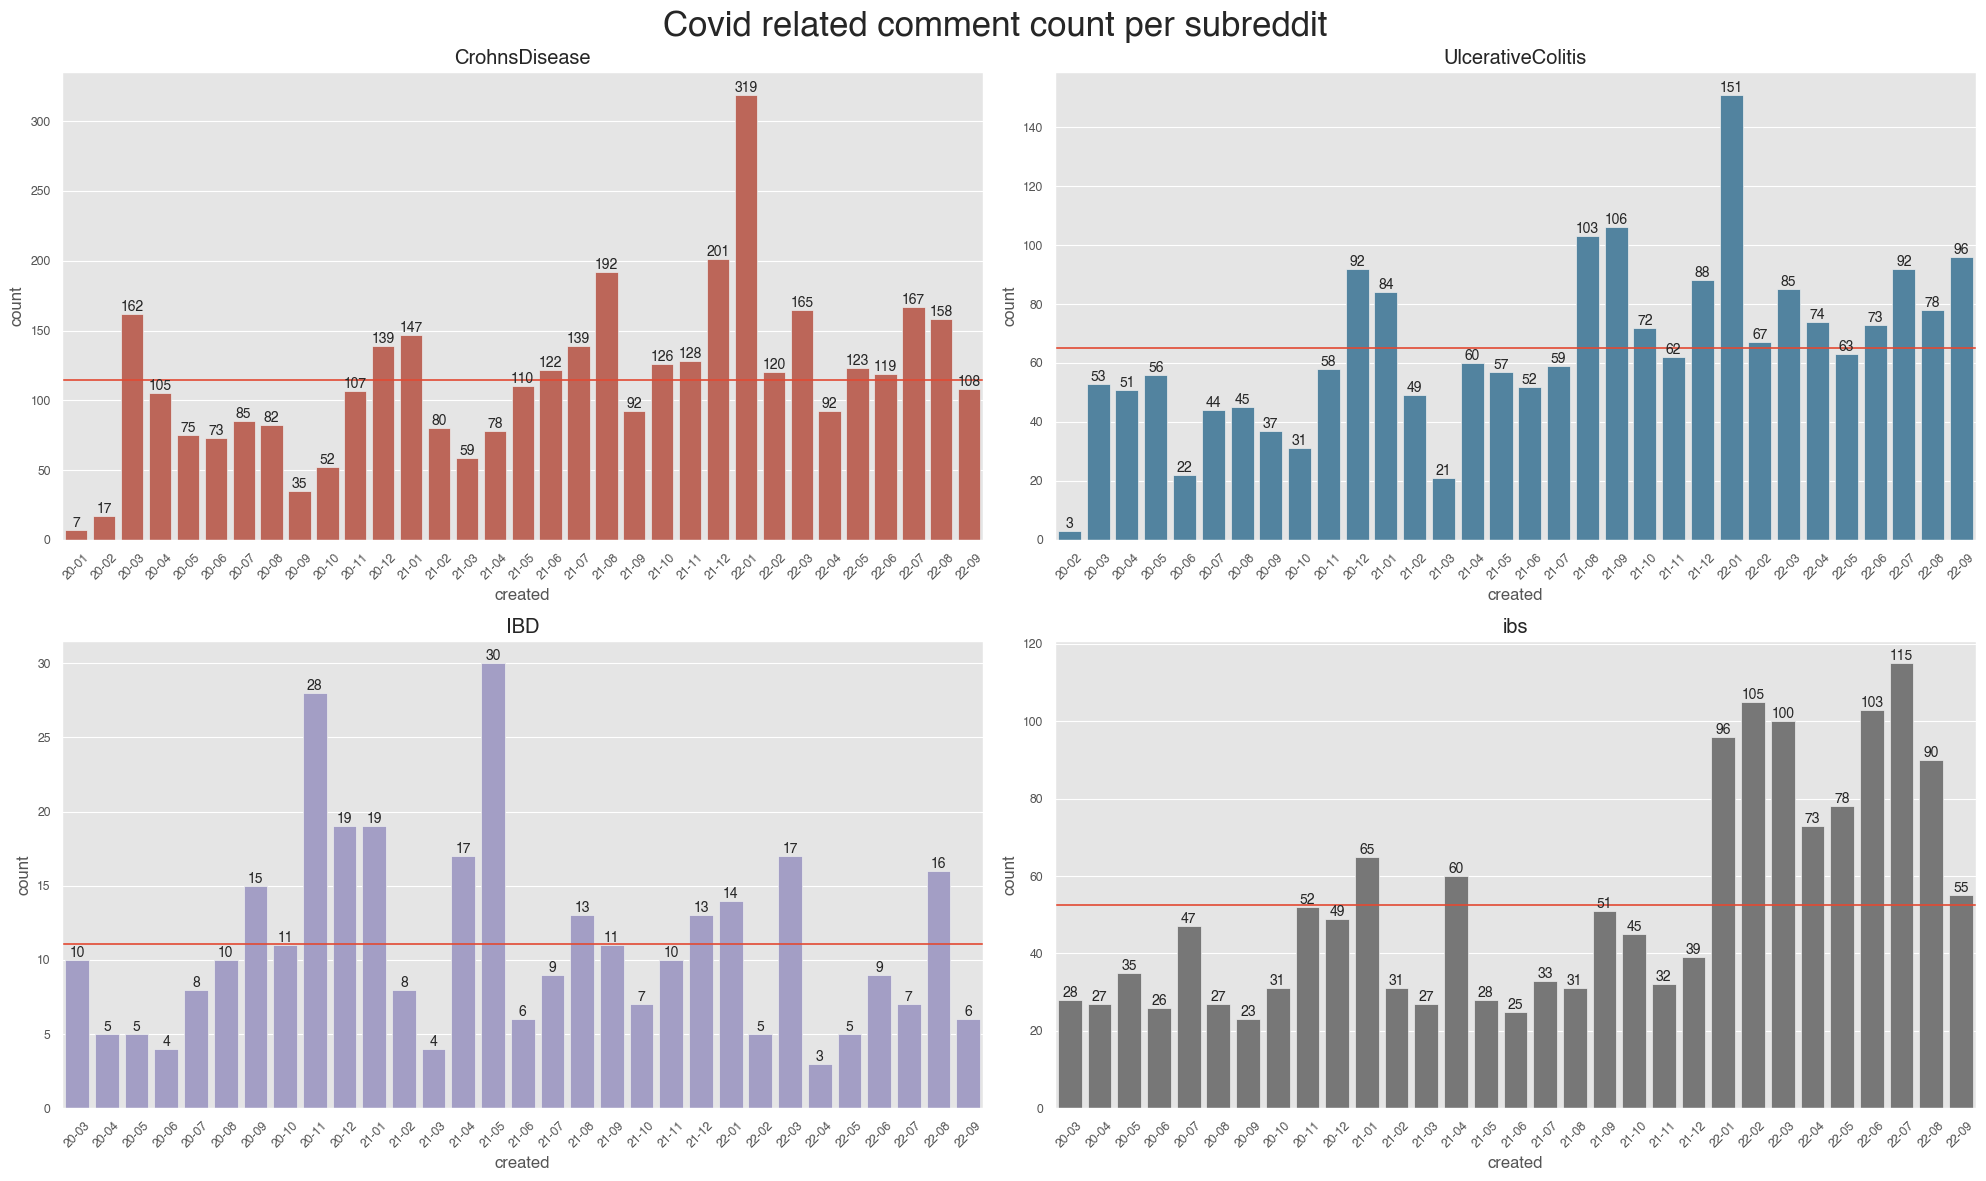

In [44]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(figsize=(20,12), nrows=2, ncols=2)

plt.suptitle('Covid related comment count per subreddit', fontsize=25)

cov_comm_crohn = df_c_comm_covid[df_c_comm_covid['subreddit'] == 'CrohnsDisease'].copy()
cov_comm_crohn.sort_values('created', inplace=True)
sns.countplot(data=cov_comm_crohn, x='created', ax=ax1, color=colors[0])
ax1.axhline(mean(df_c_comm_covid[df_c_comm_covid['subreddit'] == 'CrohnsDisease'].groupby('created').count().id))
ax1.set_title('CrohnsDisease')
ax1.bar_label(ax1.containers[0])
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

cov_comm_ulc = df_c_comm_covid[df_c_comm_covid['subreddit'] == 'UlcerativeColitis'].copy()
cov_comm_ulc.sort_values('created', inplace=True)
sns.countplot(data=cov_comm_ulc, x='created', ax=ax2, color=colors[1])
ax2.axhline(mean(df_c_comm_covid[df_c_comm_covid['subreddit'] == 'UlcerativeColitis'].groupby('created').count().id))
ax2.set_title('UlcerativeColitis')
ax2.bar_label(ax2.containers[0])
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

cov_comm_ibd = df_c_comm_covid[df_c_comm_covid['subreddit'] == 'IBD'].copy()
cov_comm_ibd.sort_values('created', inplace=True)
sns.countplot(data=cov_comm_ibd, x='created', ax=ax3, color=colors[2])
ax3.axhline(mean(df_c_comm_covid[df_c_comm_covid['subreddit'] == 'IBD'].groupby('created').count().id))
ax3.set_title('IBD')
ax3.bar_label(ax3.containers[0])
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)

cov_comm_ibs = df_c_comm_covid[df_c_comm_covid['subreddit'] == 'ibs'].copy()
cov_comm_ibs.sort_values('created', inplace=True)
sns.countplot(data=cov_comm_ibs, x='created', ax=ax4, color=colors[3])
ax4.axhline(mean(df_c_comm_covid[df_c_comm_covid['subreddit'] == 'ibs'].groupby('created').count().id))
ax4.set_title('ibs')
ax4.bar_label(ax4.containers[0])
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45)

fig.tight_layout()
plt.show();

In [45]:
fav_posts = df_filtered_covid[['title', 'author', 'subreddit', 'score', 'num_comments']].sort_values(by='score', ascending=False)
fav_posts.dropna(inplace=True)
fav_posts.num_comments = fav_posts.num_comments.astype('int64')
print(colored('\nSubmissions about covid with more upvotes', color='blue'))
display(fav_posts.iloc[0:10])


Submissions about covid with more upvotes


,title,author,subreddit,score,num_comments
12068,I had a mild case and am almost recovered from...,darknessrises8,CrohnsDisease,630,149
434,I'm getting the Pfizer vaccine tomorrow,LetsEatPizza,CrohnsDisease,562,99
8594,You Need To Fight.,YoullForgetAnyways,CrohnsDisease,305,61
291,I've had the Pfizer/BioNTech COVID-19 vaccine!,BodieJaker,CrohnsDisease,279,91
3922,PSA: Endometriosis is commonly misdiagnosed as...,meestahmoostah,ibs,273,57
24030,How many Covid screening tests have you lied on?,Smil3yAngel,ibs,267,57
9915,I’m a fully vaxxed Crohnie and I tested positi...,alaf21,CrohnsDisease,237,35
21275,Can science hurry the *uck up and find a solut...,Ok-Tour-9284,ibs,231,81
5257,"My coworkers want me to go back to the office,...",frozenfruit123,ibs,230,23
9571,Stem Cell Trial Update - Week 12 (They worked!!),AsAGayJewishDemocrat,CrohnsDisease,188,44


## T-test

A t-test is an inferential statistic used to determine if there is a statistically significant difference between the means of two variables.  

We want to check if after covid's spread the affluence in the subreddits grown

In [46]:
import researchpy as rp
import scipy.stats as stats

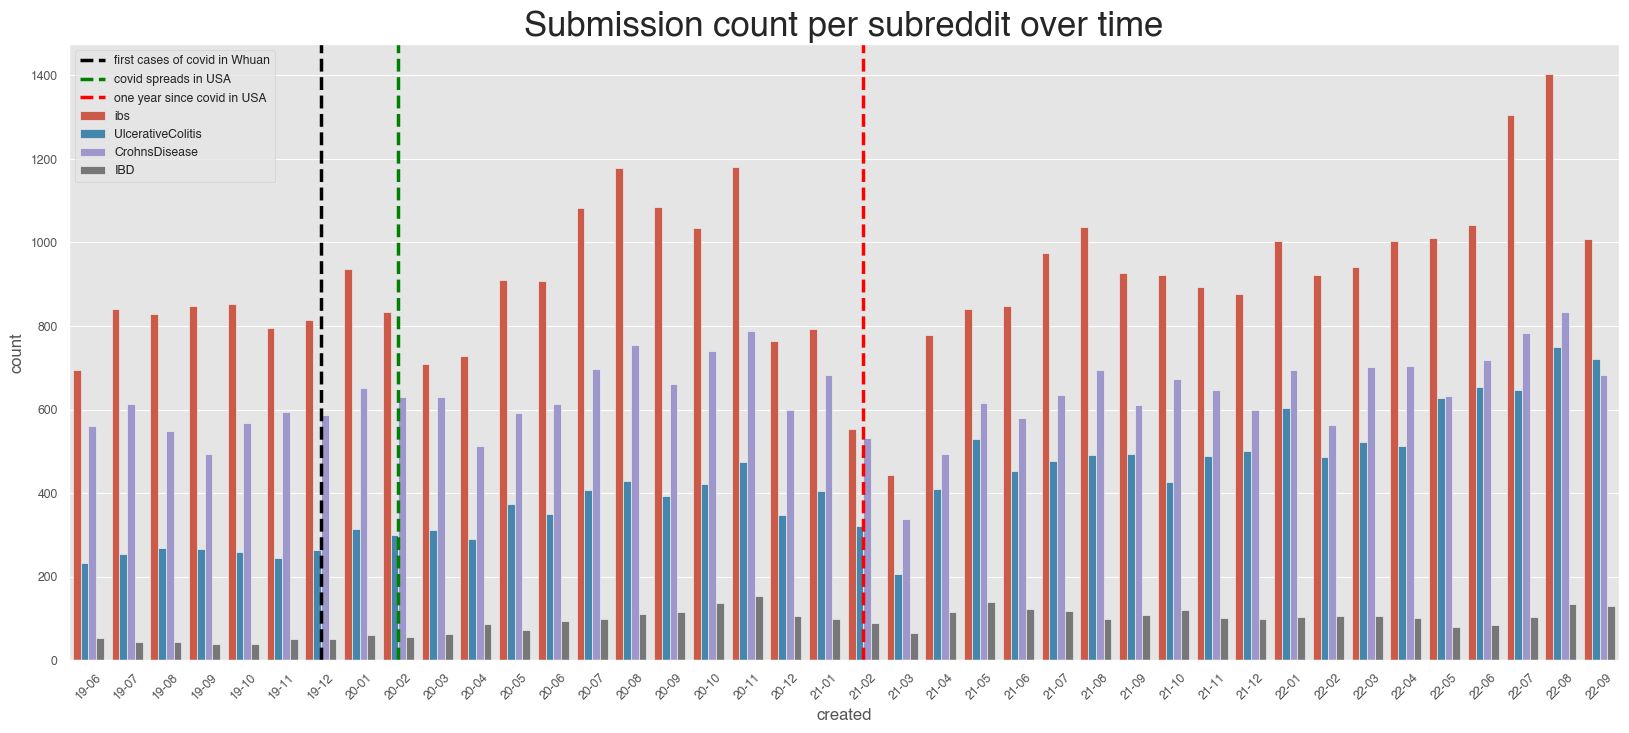

In [47]:
fig, ax = plt.subplots(figsize=(20,8))

df_c.sort_values('created', inplace=True)

plt.title('Submission count per subreddit over time', fontsize=25)
sns.countplot(data=df_c, hue='subreddit', x='created', ax=ax)
ax.axvline(x=6, linestyle='--', linewidth=2.5, color='black', label='first cases of covid in Whuan')
ax.axvline(x=8, linestyle='--', linewidth=2.5, color='green', label='covid spreads in USA')
ax.axvline(x=20, linestyle='--', linewidth=2.5, color='red', label='one year since covid in USA')
plt.xticks(rotation=45)

plt.legend()
plt.show();

In [48]:
df_sub_count_per_month = df_c.copy()
df_sub_count_per_month = df_sub_count_per_month.groupby('created').count().reset_index()
df_sub_count_per_month.drop(columns=['title', 'author', 'score', 'num_comments', 'url', 'body', 'subreddit', 'title_and_body'], inplace=True)
df_sub_count_per_month
df_sub_count_per_month.columns = ['month', 'count']

bef_cov = df_sub_count_per_month['count'][df_sub_count_per_month['month'] <= '20-02']
aft_cov = df_sub_count_per_month['count'][df_sub_count_per_month['month'] > '20-02']
one_year_cov = df_sub_count_per_month['count'][(df_sub_count_per_month['month'] > '20-02') & (df_sub_count_per_month['month'] <= '21-02')]

### Independent T-test on submission count

Before and **After** Covid

In [49]:
%%capture
summary, results = rp.ttest(group1 = bef_cov, group1_name= 'sub before covid',
     group2 = aft_cov, group2_name='sub after covid')

In [50]:
display(summary)
display(results)

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,sub before covid,9.0,1727.000000,116.132467,38.710822,1637.732683,1816.267317
1,sub after covid,31.0,2158.677419,396.737393,71.256139,2013.152969,2304.201870
2,combined,40.0,2061.550000,396.448008,62.683934,1934.759776,2188.340224


,Independent t-test,results
0,Difference (sub before covid - sub after covid...,-431.6774
1,Degrees of freedom =,38.0000
2,t =,-3.1978
3,Two side test p value =,0.0028
4,Difference < 0 p value =,0.0014
5,Difference > 0 p value =,0.9986
6,Cohen's d =,-1.2108
7,Hedge's g =,-1.1868
8,Glass's delta1 =,-3.7171
9,Point-Biserial r =,-0.4605


In [51]:
stats.ttest_ind(bef_cov, aft_cov)

Ttest_indResult(statistic=-3.1978175530992075, pvalue=0.0027900927424148805)

### Independent T-test on submission count

Before and **After one year** of Covid

In [52]:
%%capture
summary, results = rp.ttest(group1=bef_cov, group1_name= 'sub before covid', 
                            group2=one_year_cov, group2_name='sub after one year of covid')

In [53]:
display(summary)
display(results)

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,sub before covid,9.0,1727.000000,116.132467,38.710822,1637.732683,1816.267317
1,sub after one year of covid,12.0,2041.000000,349.043628,100.760216,1819.228259,2262.771741
2,combined,21.0,1906.428571,312.658371,68.227650,1764.108187,2048.748956


,Independent t-test,results
0,Difference (sub before covid - sub after one y...,-314.0000
1,Degrees of freedom =,19.0000
2,t =,-2.5794
3,Two side test p value =,0.0184
4,Difference < 0 p value =,0.0092
5,Difference > 0 p value =,0.9908
6,Cohen's d =,-1.1374
7,Hedge's g =,-1.0919
8,Glass's delta1 =,-2.7038
9,Point-Biserial r =,-0.5093


In [54]:
stats.ttest_ind(bef_cov, one_year_cov)

Ttest_indResult(statistic=-2.579398242180498, pvalue=0.018374558199315782)

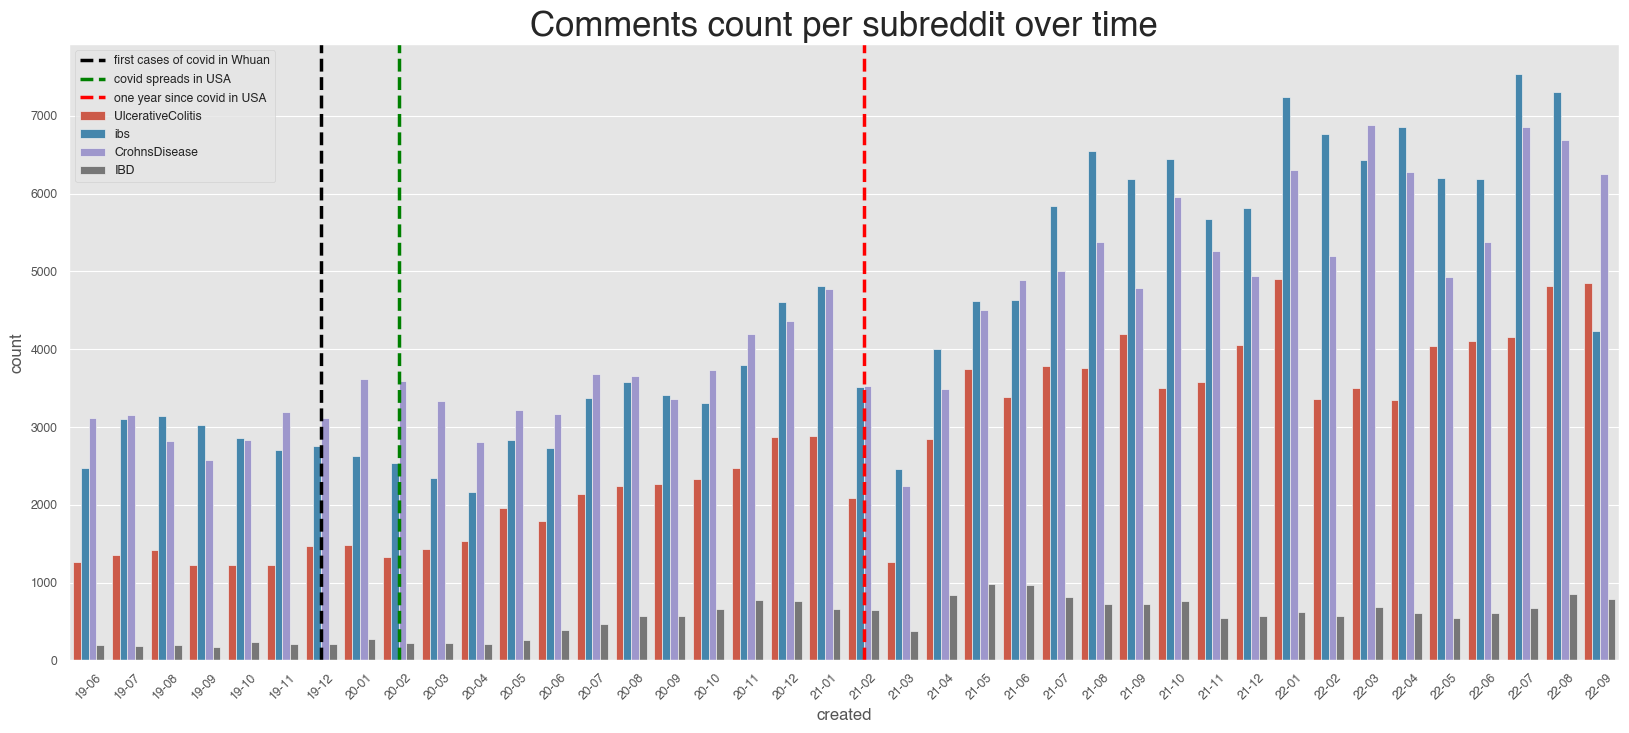

In [55]:
fig, ax = plt.subplots(figsize=(20,8))

df_c_c.sort_values('created', inplace=True)

plt.title('Comments count per subreddit over time', fontsize=25)
sns.countplot(data=df_c_c, hue='subreddit', x='created', ax=ax)
ax.axvline(x=6, linestyle='--', linewidth=2.5, color='black', label='first cases of covid in Whuan')
ax.axvline(x=8, linestyle='--', linewidth=2.5, color='green', label='covid spreads in USA')
ax.axvline(x=20, linestyle='--', linewidth=2.5, color='red', label='one year since covid in USA')
plt.xticks(rotation=45)

plt.legend()
plt.show();

In [56]:
df_comm_count_per_month = df_c_c.copy()
df_comm_count_per_month = df_comm_count_per_month.groupby('created').count().reset_index()
df_comm_count_per_month.drop(columns=['parent_id', 'author', 'score', 'body', 'subreddit'], inplace=True)
df_comm_count_per_month.columns = ['month', 'count']

comm_bef_cov = df_comm_count_per_month['count'][df_comm_count_per_month['month'] <= '20-02']
comm_aft_cov = df_comm_count_per_month['count'][df_comm_count_per_month['month'] > '20-02']
comm_one_year_cov = df_comm_count_per_month['count'][(df_comm_count_per_month['month'] > '20-02') & (df_comm_count_per_month['month'] <= '21-02')]

### Independent T-test on comment count

Before and **After** Covid

In [57]:
%%capture
summary, results = rp.ttest(group1=comm_bef_cov, group1_name='comments before covid', 
                            group2=comm_aft_cov, group2_name='comments after covid')

In [58]:
display(summary)
display(results)

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,comments before covid,9.0,7454.111111,349.212487,116.404162,7185.682631,7722.539591
1,comments after covid,31.0,13325.096774,3916.222145,703.374261,11888.614894,14761.578654
2,combined,40.0,12004.125000,4241.120644,670.580053,10647.748821,13360.501179


,Independent t-test,results
0,Difference (comments before covid - comments a...,-5870.9857
1,Degrees of freedom =,38.0000
2,t =,-4.4513
3,Two side test p value =,0.0001
4,Difference < 0 p value =,0.0000
5,Difference > 0 p value =,1.0000
6,Cohen's d =,-1.6854
7,Hedge's g =,-1.6520
8,Glass's delta1 =,-16.8121
9,Point-Biserial r =,-0.5854


In [59]:
stats.ttest_ind(comm_bef_cov, comm_aft_cov)

Ttest_indResult(statistic=-4.451301698609305, pvalue=7.246184267317047e-05)

### Independent T-test on comment count

Before and **After one year** of Covid

In [60]:
%%capture
summary, results = rp.ttest(group1=comm_bef_cov, group1_name='comments before covid', 
                            group2=comm_one_year_cov, group2_name='comments after covid')

In [61]:
display(summary)
display(results)

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,comments before covid,9.0,7454.111111,349.212487,116.404162,7185.682631,7722.539591
1,comments after covid,12.0,9706.916667,1950.529507,563.069368,8467.609344,10946.223989
2,combined,21.0,8741.428571,1856.427983,405.105798,7896.392685,9586.464458


,Independent t-test,results
0,Difference (comments before covid - comments a...,-2252.8056
1,Degrees of freedom =,19.0000
2,t =,-3.4029
3,Two side test p value =,0.0030
4,Difference < 0 p value =,0.0015
5,Difference > 0 p value =,0.9985
6,Cohen's d =,-1.5005
7,Hedge's g =,-1.4405
8,Glass's delta1 =,-6.4511
9,Point-Biserial r =,-0.6154


In [62]:
stats.ttest_ind(comm_bef_cov, comm_one_year_cov)

Ttest_indResult(statistic=-3.402905800380734, pvalue=0.002984783726641236)

### T-test comparing subreddits

In [63]:
sub_before_covid = df_c.groupby(['created', 'subreddit']).count()
sub_before_covid.reset_index(inplace=True)
sub_before_covid.drop(columns=['title', 'author', 'score', 'url', 'num_comments', 'body', 'title_and_body'], inplace=True)
sub_before_covid.columns = ['created', 'subreddit', 'count']
sub_before_covid = sub_before_covid[sub_before_covid['created'] <= '20-02']

sub_after_covid = df_c.groupby(['created', 'subreddit']).count()
sub_after_covid.reset_index(inplace=True)
sub_after_covid.drop(columns=['title', 'author', 'score', 'url', 'num_comments', 'body', 'title_and_body'], inplace=True)
sub_after_covid.columns = ['created', 'subreddit', 'count']
sub_after_covid = sub_after_covid[sub_after_covid['created'] > '20-02']

sub_one_year_covid = df_c.groupby(['created', 'subreddit']).count()
sub_one_year_covid.reset_index(inplace=True)
sub_one_year_covid.drop(columns=['title', 'author', 'score', 'url', 'num_comments', 'body', 'title_and_body'], inplace=True)
sub_one_year_covid.columns = ['created', 'subreddit', 'count']
sub_one_year_covid = sub_one_year_covid[(sub_one_year_covid['created'] > '20-02') & (sub_one_year_covid['created'] <= '21-02')]

comm_before_covid = df_c_c.groupby(['created', 'subreddit']).count()
comm_before_covid.reset_index(inplace=True)
comm_before_covid.drop(columns=['parent_id', 'author', 'score', 'body'], inplace=True)
comm_before_covid.columns = ['created', 'subreddit', 'count']
comm_before_covid = comm_before_covid[comm_before_covid['created'] <= '20-02']

comm_after_covid = df_c_c.groupby(['created', 'subreddit']).count()
comm_after_covid.reset_index(inplace=True)
comm_after_covid.drop(columns=['parent_id', 'author', 'score', 'body'], inplace=True)
comm_after_covid.columns = ['created', 'subreddit', 'count']
comm_after_covid = comm_after_covid[comm_after_covid['created'] > '20-02']

comm_one_year_covid = df_c_c.groupby(['created', 'subreddit']).count()
comm_one_year_covid.reset_index(inplace=True)
comm_one_year_covid.drop(columns=['parent_id', 'author', 'score', 'body'], inplace=True)
comm_one_year_covid.columns = ['created', 'subreddit', 'count']
comm_one_year_covid = comm_one_year_covid[(comm_one_year_covid['created'] > '20-02') & (comm_one_year_covid['created'] <= '21-02')]

In [64]:
p_values = []

for sr in subreddits:
    a = sub_before_covid[sub_before_covid['subreddit'] == sr]['count']
    b = sub_after_covid[sub_after_covid['subreddit'] == sr]['count']
    p_values.append((stats.ttest_ind(a, b).pvalue, sr, 'full period (Feb 2020 to Sept 2022)'))

for sr in subreddits:
    a = sub_before_covid[sub_before_covid['subreddit'] == sr]['count']
    b = sub_one_year_covid[sub_one_year_covid['subreddit'] == sr]['count']
    p_values.append((stats.ttest_ind(a, b).pvalue, sr, 'one year (Feb 2020 to Feb 2021)'))
    
p_values = pd.DataFrame(p_values, columns=['p_value', 'subreddit', 'type'])

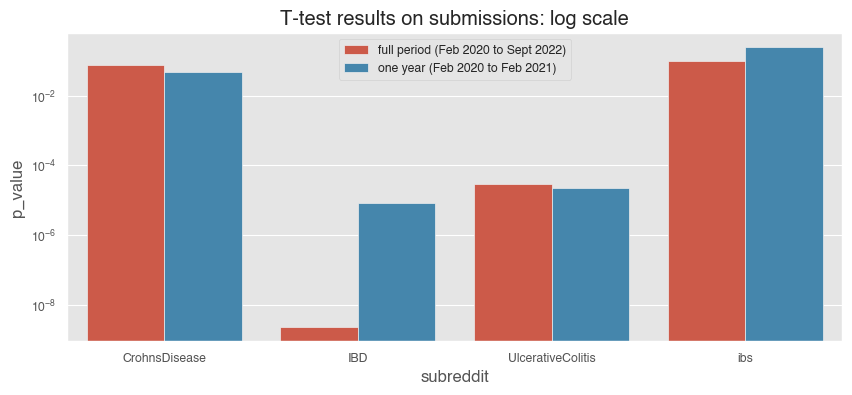

In [65]:
fig, ax = plt.subplots(figsize=(10,4))

plt.title('T-test results on submissions: log scale')
sns.barplot(data=p_values, hue='type', x=p_values.subreddit, y=p_values.p_value, log=True)

plt.legend()
plt.show();

In [66]:
p_values = []

for sr in subreddits:
    a = comm_before_covid[comm_before_covid['subreddit'] == sr]['count']
    b = comm_after_covid[comm_after_covid['subreddit'] == sr]['count']
    p_values.append((stats.ttest_ind(a, b).pvalue, sr, 'full period (Feb 2020 to Sept 2022)'))

for sr in subreddits:
    a = comm_before_covid[sub_before_covid['subreddit'] == sr]['count']
    b = comm_one_year_covid[comm_one_year_covid['subreddit'] == sr]['count']
    p_values.append((stats.ttest_ind(a, b).pvalue, sr, 'one year (Feb 2020 to Feb 2021)'))
    
p_values = pd.DataFrame(p_values, columns=['p_value', 'subreddit', 'type'])

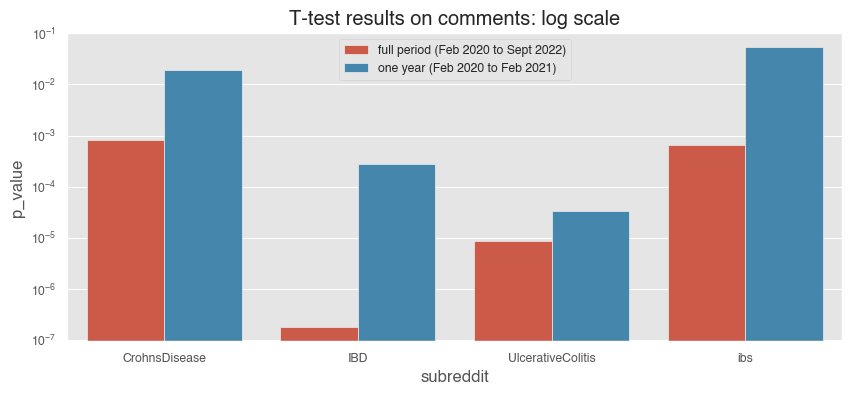

In [67]:
fig, ax = plt.subplots(figsize=(10,4))

plt.title('T-test results on comments: log scale')
sns.barplot(data=p_values, hue='type', x=p_values.subreddit, y=p_values.p_value, log=True)

plt.legend()
plt.show();